In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics



In [2]:
def spatial_merge_left_join(plants_df, atmospheric_df):
    
    gdf_plants = gpd.GeoDataFrame(
        plants_df,
        geometry=gpd.points_from_xy(plants_df.Longitude, plants_df.Latitude),
        crs="EPSG:4326"
    )
    
    gdf_atmospheric = gpd.GeoDataFrame(
        atmospheric_df,
        geometry=gpd.points_from_xy(atmospheric_df.LONGITUDE, atmospheric_df.LATITUDE),
        crs="EPSG:4326"
    )

    LOCAL_CRS = "EPSG:5070" 
    gdf_plants_proj = gdf_plants.to_crs(LOCAL_CRS)
    gdf_atmospheric_proj = gdf_atmospheric.to_crs(LOCAL_CRS)

    power_plants_merged_gdf = gpd.sjoin_nearest(
        gdf_plants_proj, 
        gdf_atmospheric_proj,
        how="left", 
        distance_col="distance_meters"
    )
    
    power_plants_merged_gdf['distance_to_match'] = power_plants_merged_gdf['distance_meters'] / 1000.0

    final_df = pd.DataFrame(power_plants_merged_gdf.drop(columns=['geometry', 'index_right', 'distance_meters']))

    return final_df


def plot_map(map_title,
             x,
             y,
             c='blue',
             labels=None,
             cmap=False,
             s=1,
             edgecolor=None,
             linewidths=None,
             alpha=1,
             zorder=1):
    fig = plt.figure(figsize=(20,9))

    _map = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

    _map.stock_img()

    _map.add_feature(cfeature.LAND, color='lightgray')

    _map.add_feature(cfeature.OCEAN, color='lightblue')

    _map.add_feature(cfeature.COASTLINE)

    _map.add_feature(cfeature.BORDERS, linestyle=':')

    _map.add_feature(cfeature.LAKES, alpha=0.5, color='lightblue')

    _map.add_feature(cfeature.RIVERS)

    if cmap:
        if edgecolor is not None:
            _map.scatter(x,
                         y,
                         c=c,
                         s=s,
                         cmap=cmap,
                         edgecolor=edgecolor,
                         linewidths=linewidths,
                         alpha=alpha,
                         zorder=zorder,
                         transform=ccrs.PlateCarree())
            
        else:
            _map.scatter(x,
                         y,
                         c=c,
                         s=s,
                         cmap=cmap,
                         alpha=alpha,
                         zorder=zorder,
                         transform=ccrs.PlateCarree())
        
    else:
        _map.scatter(x,
                     y,
                     c=c,
                     s=s,
                     alpha=alpha,
                     zorder=zorder,
                     transform=ccrs.PlateCarree())

    gl = _map.gridlines(draw_labels=True,
                        dms=True,
                        x_inline=False,
                        y_inline=False,
                        color='gray',
                        linestyle='--')

    gl.top_labels = False

    gl.right_labels = False
    
    handles = []

    if labels is not None:
        for i, category in enumerate(categories):
            handle = mlines.Line2D([], [], color=cmap(i), marker='o', linestyle='None',
                              markersize=10, label=category)

            handles.append(handle)

        _map.legend(handles=handles, title=f"{map_title}", bbox_to_anchor=(0, 0), loc='lower left')

    _map.set_title(f"{map_title}")

    plt.show()

# =============================================================================
# Code generated by Artificial Intelligence (Google AI)
# Date: 2025-12-05
# Prompt: "Python function to convert degrees F to degrees C"
# =============================================================================
def fahrenheit_to_celsius(fahrenheit_temp):
    """
    Converts a temperature from Fahrenheit (°F) to Celsius (°C).
    """
    celsius_temp = (fahrenheit_temp - 32) * 5/9
    return celsius_temp

# =============================================================================
# Code generated by Artificial Intelligence (Google AI)
# Date: 2025-12-05
# Prompt: "Python function to calculate relative humidity from NCEI dataset."
# =============================================================================
def calculate_relative_humidity(x):
    """
    Calculates relative humidity (%) using the Magnus approximation and accounts for pressure.
    
    Args:
        temperature_celsius (float): The current ambient air temperature in Celsius.
        dew_point_celsius (float): The dew point temperature in Celsius.
        station_pressure_hpa (float): The actual pressure at the station level in Hectopascals (hPa) or millibars (mb).
        
    Returns:
        float: The calculated relative humidity as a percentage.
    """
    
    temperature_celsius = x['TEMP_C']
    
    dew_point_celsius = x['DEWP']
    
    station_pressure_hpa = x['STP']
    
    # 1. Calculate Saturation Vapor Pressure (es) at current T (Magnus-Tetens formula)
    # Constants used for water vapor over water
    A = 17.625
    B = 243.04
    es = 6.112 * np.exp((A * temperature_celsius) / (B + temperature_celsius))
    # 2. Calculate Actual Vapor Pressure (e) at Td (e is es at dew point)
    e = 6.112 * np.exp((A * dew_point_celsius) / (B + dew_point_celsius))
    # 3. Apply the Enhancement Factor (f) - This is where pressure comes in
    # This factor corrects for the behavior of moist air at different pressures.
    f = 1 + (1e-6 * station_pressure_hpa * (4.5 + 6e-4 * temperature_celsius**2))
    # 4. Calculate RH
    # RH = (e / (f * es)) * 100
    # For most standard uses, f is very close to 1, and often omitted. 
    # The calculation is robust without it, but more reliable with it.
    
    RH = (e / (f * es)) * 100
    
    # Constrain the result to physical limits
    RH = max(0, min(100, RH))
    return RH

def plot_impact(y_test, y_pred, model_pipeline, model_name):
    # 1. Get the classification report as a dictionary
    report_dict = metrics.classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # 2. Convert the dictionary to a pandas DataFrame and transpose it
    df_report = pd.DataFrame(report_dict).T
    
    # Optional: Convert 'support' column to integer type
    df_report['support'] = df_report['support'].astype(int)
    
    # 3. Plot the DataFrame as a heatmap (excluding 'support' as it's counts, not scores)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='plasma', fmt=".2f")
    plt.title(f'{model_name} Classification Report Heatmap')
    plt.show()

    # *********************************************************
    # FIX IS HERE: Get the actual fitted model object from the pipeline
    # *********************************************************
    fitted_estimator = model_pipeline.named_steps[model_name]
    # Also need feature_names defined correctly from the input data X_train
    feature_names = X_train.columns 

    # Plot 2: Feature Importances Bar Chart
    plt.figure(figsize=(14, 20))

    if model_name in ['random_forest', 'decision_tree']:
        # Use fitted_estimator instead of the whole pipeline (model variable)
        importances = pd.Series(fitted_estimator.feature_importances_, index=feature_names).sort_values(ascending=False)
        sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')
        plt.title(f'{model_name} Feature Importances (Mean Decrease in Impurity)')
        plt.xlabel('Importance Score')
    
    elif model_name == 'logistic_regression':
        # Use fitted_estimator instead of the whole pipeline (model variable)
        if fitted_estimator.coef_.ndim > 1:
            coefs_mean = np.mean(np.abs(fitted_estimator.coef_), axis=0)
        else:
            coefs_mean = np.abs(fitted_estimator.coef_)
            
        importances = pd.Series(coefs_mean, index=feature_names).sort_values(ascending=False)
        sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')
        plt.title(f'{model_name} Feature Importances (Mean Absolute Coefficients)')
        plt.xlabel('Absolute Coefficient Value') # Changed slabel to xlabel
        
    plt.show() # Added this to display the second plot

def run_model(model_name, model_function, X_train, X_test, y_train, y_test, build_plot=False):
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_name, model_function)
    ])

    # Fit the pipeline
    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)

    # --- Metrics calculations remain the same ---
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_score = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=0)

    if build_plot:
        plot_impact(y_test, y_pred, model_pipeline, model_name)
    
    return accuracy_score, precision_score, recall_score, f1_score

<h3>Step 3: Integrate Discovered Features into Predictive Models</h3>

<blockquote>Take the features you discovered in Phase 1 (cluster memberships, principal components, or derived features) and integrate them into your predictive models. You have options:

If you did clustering:

[x]Add cluster membership as a new feature in your prediction models.<br>
OR[ ]predict within each cluster separately.<br>
OR[ ]use clusters to create new engineered features (e.g., "distance from cluster center").<br></blockquote>


In [3]:
ncei_stations_id = pd.read_csv('data/ncei_stations_id.csv', index_col=0)

In [4]:
monthly_pivot = pd.read_csv('data/monthly_pivot.csv', index_col=0)

In [5]:
power_plants = pd.read_csv('data/power_plant_distance_to_water.csv', index_col=0)

In [6]:
ncei_atmospheric_aggregate = pd.read_csv('data/ncei_atmospheric_aggregate.csv', index_col=0)

In [7]:
full_atmospheric_w_id = pd.read_csv('data/full_atmospheric_w_id.csv', index_col=0)

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3299351841.py:1: DtypeWarning: Columns (135) have mixed types. Specify dtype option on import or set low_memory=False.
  full_atmospheric_w_id = pd.read_csv('data/full_atmospheric_w_id.csv', index_col=0)


In [8]:
monthly_pivot_w_stations = monthly_pivot.merge(ncei_stations_id, on='NAME', how='left')

# data quality issue
monthly_pivot_w_stations = monthly_pivot_w_stations.dropna()

print(f"{monthly_pivot_w_stations.head(5)}")

                                      NAME     1_TEMP     2_TEMP     3_TEMP  \
0  068 BAFFIN BAY POINT OF ROCKS TX, TX US  55.030645  61.121053  67.901724   
1              9014098 FORT GRATIOT MI, US  24.872581  29.710714  39.132759   
2                    9052030 OSWEGO NY, US  27.512903  30.026786  39.381034   
3                   9063020 BUFFALO NY, US  27.285484  29.584211  37.920690   
4              9075014 HARBOR BEACH MI, US  24.391935  28.058929  35.505172   

      4_TEMP     5_TEMP     6_TEMP     7_TEMP     8_TEMP     9_TEMP  ...  \
0  73.383333  79.854098  83.390000  82.854839  84.477778  81.543333  ...   
1  46.596491  55.336066  67.819643  71.725806  71.140741  66.320000  ...   
2  46.408929  57.111475  67.585000  73.332258  70.574074  65.746667  ...   
3  45.516667  57.940984  67.696667  73.688710  71.751852  67.973333  ...   
4  43.260000  51.595082  63.859322  69.646774  69.653704  65.363333  ...   

   11_PRCP  12_PRCP  CLIMATE ZONE n_clusters=2  CLIMATE ZONE n_clust

In [9]:
merged_df = spatial_merge_left_join(power_plants, monthly_pivot_w_stations)

merged_df = merged_df.groupby('gppd_idnr').first()

print(f"{merged_df.head(5)}")

                Powerplant Name  Capacity (MW) Primary Fuel  \
gppd_idnr                                                     
ARG0000001               PARANA         845.26        Other   
ARG0000002          SAN NICOLAS         644.00         Coal   
ARG0000003         CT ARRECIFES          20.00          Oil   
ARG0000004  CT GENERAL VILLEGAS          23.49          Oil   
ARG0000005         CT MAGDALENA          25.00          Oil   

                                    Owner                           Source  \
gppd_idnr                                                                    
ARG0000001  AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
ARG0000002  AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
ARG0000003          AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
ARG0000004          AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
ARG0000005                 APR ENERGY SRL  Ministerio de Energía y Minería   

           

In [10]:
merged_df[merged_df==np.nan].count().count()

42

In [11]:
# data quality issue
merged_df = merged_df.fillna(0)

merged_df[merged_df.isnull()].count().count()

42

In [12]:
merged_df

Powerplant Name  Capacity (MW) Primary Fuel  \
gppd_idnr                                                             
ARG0000001                       PARANA         845.26        Other   
ARG0000002                  SAN NICOLAS         644.00         Coal   
ARG0000003                 CT ARRECIFES          20.00          Oil   
ARG0000004          CT GENERAL VILLEGAS          23.49          Oil   
ARG0000005                 CT MAGDALENA          25.00          Oil   
...                                 ...            ...          ...   
WRI1075859    Vidin Works power station         120.00         Coal   
WRI1075860         Kelvin power station         600.00         Coal   
WRI1075861  Pretoria West power station         180.00         Coal   
WRI1075862        Rooiwal power station         300.00         Coal   
WRI1075863    Sultan Aziz power station        1600.00         Coal   

                                    Owner                           Source  \
gppd_idnr                                                                    
ARG0000001  AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
ARG0000002  AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
ARG0000003          AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
ARG0000004          AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
ARG0000005                 APR ENERGY SRL  Ministerio de Energía y Minería   
...                                   ...                              ...   
WRI1075859                       Vidachim                             GCPT   
WRI1075860      Aldwych International Ltd                             GCPT   
WRI1075861                              0                             GCPT   
WRI1075862   Tshwane Electricity Division                             GCPT   
WRI1075863  Kapar Energy Ventures Sdn Bhd                             GCPT   

            distance_to_water_km  Longitude  Latitude  \
gppd_idnr                                               
ARG0000001              0.581258   -60.1718  -33.3549   
ARG0000002              0.721664   -60.1729  -33.3562   
ARG0000003             41.358227   -60.1297  -34.0414   
ARG0000004            156.359842   -62.9981  -35.0347   
ARG0000005              0.000000   -57.4839  -35.1001   
...                          ...        ...       ...   
WRI1075859              1.213469    22.8509   43.9484   
WRI1075860             50.922046    28.1940  -26.1158   
WRI1075861             71.556524    28.1467  -25.7584   
WRI1075862             59.081717    28.2376  -25.5550   
WRI1075863              1.377578   101.3204    3.1172   

                                                NAME     1_TEMP  ...  \
gppd_idnr                                                        ...   
ARG0000001                               ROSARIO, AR  78.119355  ...   
ARG0000002                               ROSARIO, AR  78.119355  ...   
ARG0000003                               ROSARIO, AR  78.119355  ...   
ARG0000004                             LABOULAYE, AR  79.900000  ...   
ARG0000005                      PUNTA INDIO B.A., AR  77.449057  ...   
...                                              ...        ...  ...   
WRI1075859                                 VIDIN, BU  35.304839  ...   
WRI1075860                        PRETORIA IRENE, SF  70.473684  ...   
WRI1075861                        PRETORIA UNISA, SF  71.439130  ...   
WRI1075862                            WONDERBOOM, SF  73.770175  ...   
WRI1075863  SULTAN ABDUL AZIZ SHAH INTERNATIONAL, MY  81.916129  ...   

             12_PRCP  CLIMATE ZONE n_clusters=2  CLIMATE ZONE n_clusters=5  \
gppd_idnr                                                                    
ARG0000001  0.000833                          1                          2   
ARG0000002  0.000833                          1                          2   
ARG0000003  0.000833                          1                          2   
ARG0000004  0.00

In [13]:
atmospheric_features = [
'DEWP', 'SLP','STP','VISIB','WDSP',
'MXSPD','GUST','MAX','MIN','RH'
]

In [14]:
ncei_atmospheric_aggregate[ncei_atmospheric_aggregate==999.9] = 0

ncei_atmospheric_aggregate[ncei_atmospheric_aggregate==9999.9] = 0

ncei_atmospheric_aggregate['TEMP_C'] = ncei_atmospheric_aggregate['TEMP'].apply(lambda x: fahrenheit_to_celsius(x))

ncei_atmospheric_aggregate['RH'] = ncei_atmospheric_aggregate.apply(lambda x: calculate_relative_humidity(x), axis=1)

In [15]:
pivot_df_full = []

numeric_features = ['distance_to_water_km']

for feature in atmospheric_features:
    tmp_pivot = ncei_atmospheric_aggregate.reset_index(drop=True).pivot_table(
    index='NAME',       # The row labels will be the station names
    columns='MONTH',    # The new columns will be the month numbers (1-12)
    values=f'{feature}',      # The data to fill the cells will come from the 'TEMP' column
    aggfunc='mean'      # If a station has multiple entries for a month, take the average
)
    
    atmospheric_features = [str(i)+f'_{feature}' for i in range(1,13)]
    
    tmp_pivot.columns = atmospheric_features
    
    numeric_features += atmospheric_features
    
    pivot_df_full.append(tmp_pivot)
    
pivot_df = pd.concat(pivot_df_full, axis=1)

pivot_df

1_DEWP     2_DEWP     3_DEWP  \
NAME                                                                       
068 BAFFIN BAY POINT OF ROCKS TX, TX US   0.000000   0.000000   0.000000   
9014098 FORT GRATIOT MI, US              17.369355  21.032143  28.501754   
9052030 OSWEGO NY, US                    20.354839  21.769643  28.750000   
9063020 BUFFALO NY, US                   21.066129  22.224561  28.906897   
9075014 HARBOR BEACH MI, US              18.716129  21.766071  28.473684   
...                                            ...        ...        ...   
ZUZ AGAC, KZ                              9.070968   3.236842  22.362069   
ZVARTNOTS, AM                            24.332258  21.463158  27.998276   
ZWERNDORF MARCHEGG, AU                   28.974194  31.601754  35.644643   
ZYRJANOVSK, KZ                           -3.698387 -11.396491  10.891379   
ZYRYANKA, RS                            -43.343548 -35.550877 -16.801724   

                                            4_DEWP     5_DEWP     6_DEWP  \
NAME                                                                       
068 BAFFIN BAY POINT OF ROCKS TX, TX US   0.000000   0.000000   0.000000   
9014098 FORT GRATIOT MI, US              35.070175  47.540984  57.307143   
9052030 OSWEGO NY, US                    36.705357  49.491803  58.118333   
9063020 BUFFALO NY, US                   35.793333  49.927869  59.318333   
9075014 HARBOR BEACH MI, US              35.200000  45.847541  56.649153   
...                                            ...        ...        ...   
ZUZ AGAC, KZ                             36.910345  45.088525  49.870000   
ZVARTNOTS, AM                            38.063333  44.995082  44.221667   
ZWERNDORF MARCHEGG, AU                   42.165000  47.496552  56.433898   
ZYRJANOVSK, KZ                           32.587931  47.742623  57.621667   
ZYRYANKA, RS                             10.484483  28.124590  44.061667   

                                            7_DEWP     8_DEWP     9_DEWP  \
NAME                                                                       
068 BAFFIN BAY POINT OF ROCKS TX, TX US   0.000000   0.000000   0.000000   
9014098 FORT GRATIOT MI, US              62.862903  61.842593  57.203333   
9052030 OSWEGO NY, US                    64.325806  61.516667  57.693333   
9063020 BUFFALO NY, US                   64.848387  62.235185  57.813333   
9075014 HARBOR BEACH MI, US              63.367742  62.846296  59.390000   
...                                            ...        ...        ...   
ZUZ AGAC, KZ                             51.400000  47.777778  37.710000   
ZVARTNOTS, AM                            51.429032  49.685185  47.730000   
ZWERNDORF MARCHEGG, AU                   57.645161  57.422222  51.110000   
ZYRJANOVSK, KZ                           59.172581  54.346296  38.180000   
ZYRYANKA, RS                             50.627419  44.362963  35.790000   

                                           10_DEWP  ...        3_RH  \
NAME                                                ...               
068 BAFFIN BAY POINT OF ROCKS TX, TX US   0.000000  ...   26.270606   
9014098 FORT GRATIOT MI, US              43.119355  ...  100.000000   
9052030 OSWEGO NY, US                    44.829032  ...  100.000000   
9063020 BUFFALO NY, US                   46.022581  ...  100.000000   
9075014 HARBOR BEACH MI, US              44.306452  ...  100.000000   
...                                            ...  ...         ...   
ZUZ AGAC, KZ                             34.687097  ...  100.000000   
ZVARTNOTS, AM                            37.677419  ...  100.000000   
ZWERNDORF MARCHEGG, AU                   46.887097  ...  100.000000   
ZYRJANOVSK, KZ                           35.564516  ...  100.000000   
ZYRYANKA, RS                             13.770968  ...  100.000000   

                                               4_RH        5_RH        6_RH  \
NAME                                                                      

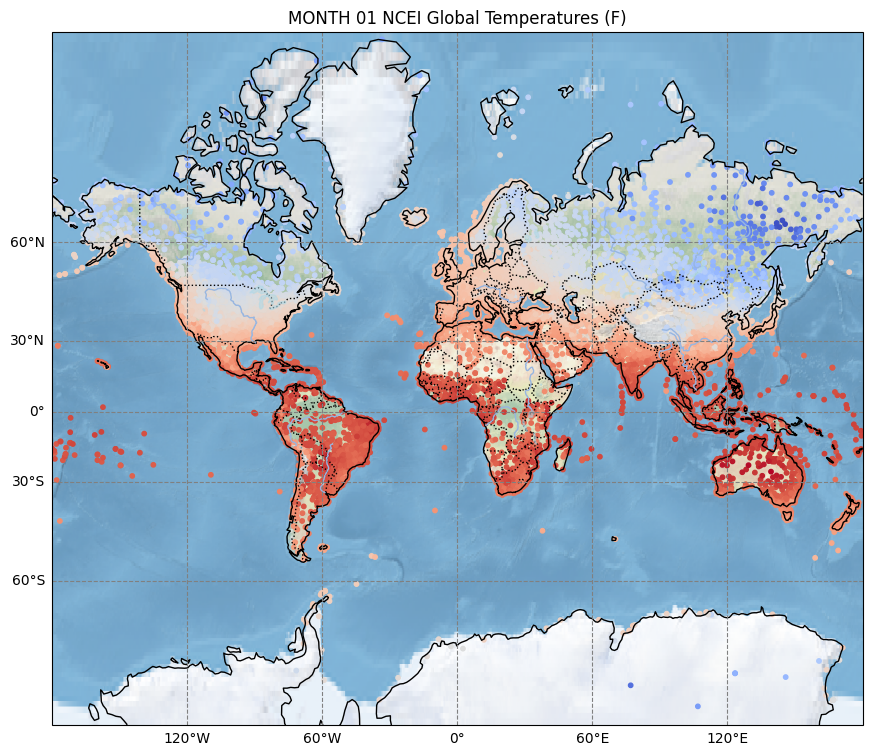

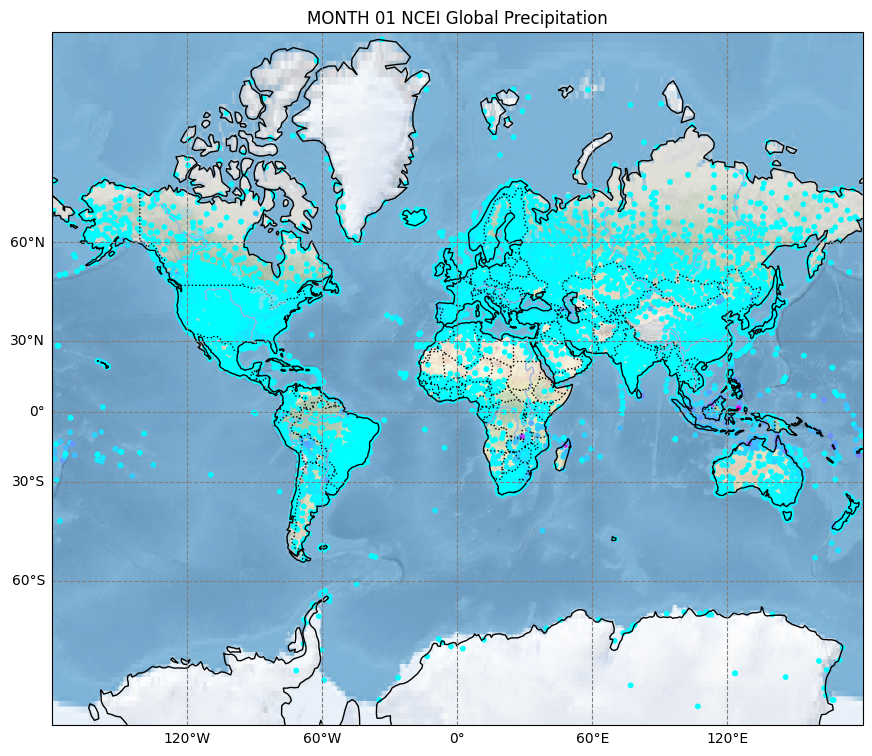

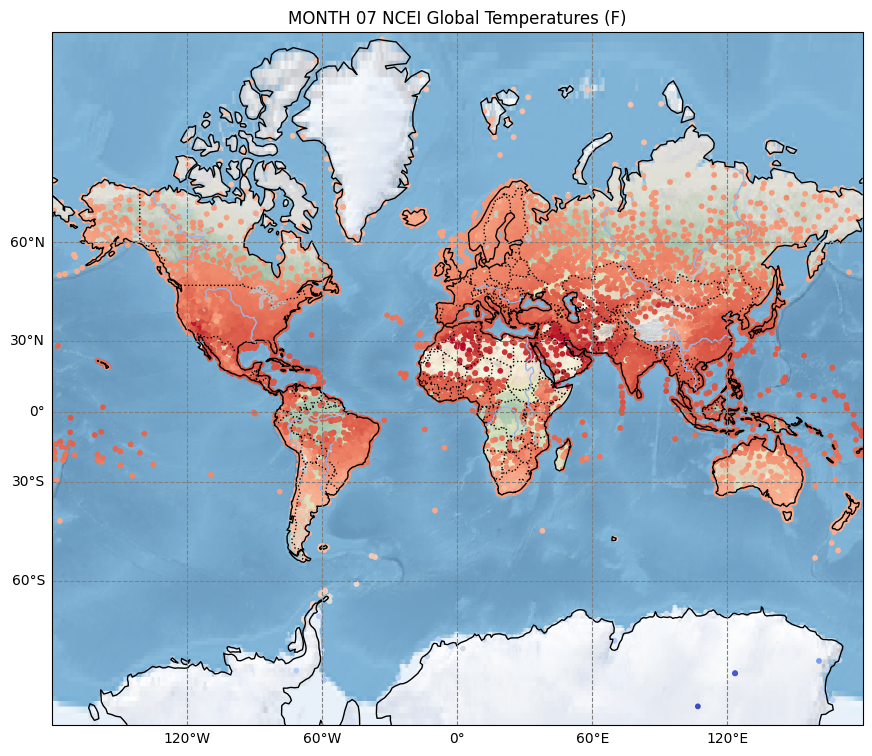

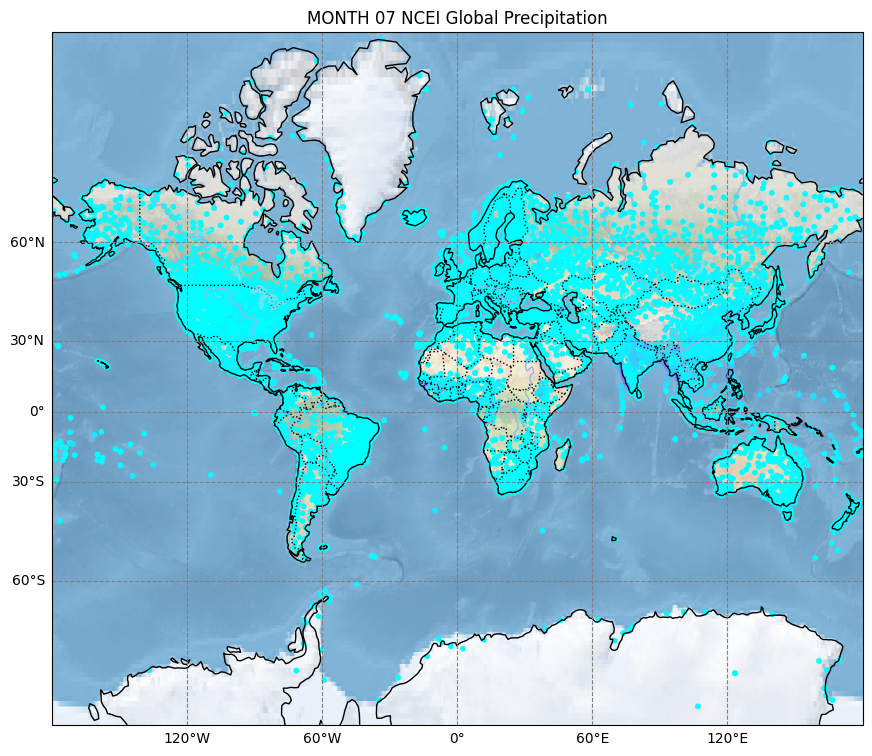

In [16]:
plot_map("MONTH 01 NCEI Global Temperatures (F)",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['1_TEMP'],
         labels=None,
         cmap='coolwarm',
         s=10)

plot_map("MONTH 01 NCEI Global Precipitation",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['1_PRCP'],
         labels=None,
         cmap='cool',
         s=10)

plot_map("MONTH 07 NCEI Global Temperatures (F)",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['7_TEMP'],
         labels=None,
         cmap='coolwarm',
         s=10)

plot_map("MONTH 07 NCEI Global Precipitation",
         full_atmospheric_w_id['LONGITUDE'],
         full_atmospheric_w_id['LATITUDE'],
         full_atmospheric_w_id['7_PRCP'],
         labels=None,
         cmap='cool',
         s=10)

In [17]:
new_features = []

k_values = [2,5,11]

for n_clusters in k_values:
    new_features.append(f"CLIMATE ZONE n_clusters={n_clusters}")
    
print(new_features)

['CLIMATE ZONE n_clusters=2', 'CLIMATE ZONE n_clusters=5', 'CLIMATE ZONE n_clusters=11']


In [18]:
numeric_features_full = numeric_features + new_features

print(numeric_features_full)

['distance_to_water_km', '1_DEWP', '2_DEWP', '3_DEWP', '4_DEWP', '5_DEWP', '6_DEWP', '7_DEWP', '8_DEWP', '9_DEWP', '10_DEWP', '11_DEWP', '12_DEWP', '1_SLP', '2_SLP', '3_SLP', '4_SLP', '5_SLP', '6_SLP', '7_SLP', '8_SLP', '9_SLP', '10_SLP', '11_SLP', '12_SLP', '1_STP', '2_STP', '3_STP', '4_STP', '5_STP', '6_STP', '7_STP', '8_STP', '9_STP', '10_STP', '11_STP', '12_STP', '1_VISIB', '2_VISIB', '3_VISIB', '4_VISIB', '5_VISIB', '6_VISIB', '7_VISIB', '8_VISIB', '9_VISIB', '10_VISIB', '11_VISIB', '12_VISIB', '1_WDSP', '2_WDSP', '3_WDSP', '4_WDSP', '5_WDSP', '6_WDSP', '7_WDSP', '8_WDSP', '9_WDSP', '10_WDSP', '11_WDSP', '12_WDSP', '1_MXSPD', '2_MXSPD', '3_MXSPD', '4_MXSPD', '5_MXSPD', '6_MXSPD', '7_MXSPD', '8_MXSPD', '9_MXSPD', '10_MXSPD', '11_MXSPD', '12_MXSPD', '1_GUST', '2_GUST', '3_GUST', '4_GUST', '5_GUST', '6_GUST', '7_GUST', '8_GUST', '9_GUST', '10_GUST', '11_GUST', '12_GUST', '1_MAX', '2_MAX', '3_MAX', '4_MAX', '5_MAX', '6_MAX', '7_MAX', '8_MAX', '9_MAX', '10_MAX', '11_MAX', '12_MAX', '1_

In [19]:
numeric_merged_df = merged_df.merge(pivot_df, on='NAME', how='inner')

numeric_merged_df

Powerplant Name  Capacity (MW) Primary Fuel  \
0                           PARANA         845.26        Other   
1                      SAN NICOLAS         644.00         Coal   
2                     CT ARRECIFES          20.00          Oil   
3              CT GENERAL VILLEGAS          23.49          Oil   
4                     CT MAGDALENA          25.00          Oil   
...                            ...            ...          ...   
29905    Vidin Works power station         120.00         Coal   
29906         Kelvin power station         600.00         Coal   
29907  Pretoria West power station         180.00         Coal   
29908        Rooiwal power station         300.00         Coal   
29909    Sultan Aziz power station        1600.00         Coal   

                               Owner                           Source  \
0      AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
1      AES ARGENTINA GENERACION S.A.  Ministerio de Energía y Minería   
2              AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
3              AGGREKO ARGENTINA SRL  Ministerio de Energía y Minería   
4                     APR ENERGY SRL  Ministerio de Energía y Minería   
...                              ...                              ...   
29905                       Vidachim                             GCPT   
29906      Aldwych International Ltd                             GCPT   
29907                              0                             GCPT   
29908   Tshwane Electricity Division                             GCPT   
29909  Kapar Energy Ventures Sdn Bhd                             GCPT   

       distance_to_water_km  Longitude  Latitude  \
0                  0.581258   -60.1718  -33.3549   
1                  0.721664   -60.1729  -33.3562   
2                 41.358227   -60.1297  -34.0414   
3                156.359842   -62.9981  -35.0347   
4                  0.000000   -57.4839  -35.1001   
...                     ...        ...       ...   
29905              1.213469    22.8509   43.9484   
29906             50.922046    28.1940  -26.1158   
29907             71.556524    28.1467  -25.7584   
29908             59.081717    28.2376  -25.5550   
29909              1.377578   101.3204    3.1172   

                                           NAME     1_TEMP  ...   3_RH   4_RH  \
0                                   ROSARIO, AR  78.119355  ...  100.0  100.0   
1                                   ROSARIO, AR  78.119355  ...  100.0  100.0   
2                                   ROSARIO, AR  78.119355  ...  100.0  100.0   
3                                 LABOULAYE, AR  79.900000  ...  100.0  100.0   
4                          PUNTA INDIO B.A., AR  77.449057  ...  100.0  100.0   
...                                         ...        ...  ...    ...    ...   
29905                                 VIDIN, BU  35.304839  ...  100.0  100.0   
29906                        PRETORIA IRENE, SF  70.473684  ...  100.0  100.0   
29907                        PRETORIA UNISA, SF  71.439130  ...  100.0  100.0   
29908                            WONDERBOOM, SF  73.770175  ...  100.0  100.0   
29909  SULTAN ABDUL AZIZ SHAH INTERNATIONAL, MY  81.916129  ...  100.0  100.0   

        5_RH   6_RH   7_RH   8_RH   9_RH  10_RH  11_RH  12_RH  
0      100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
1      100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
2      100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
3      100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
4      100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
...      ...    ...    ...    ...    ...    ...    ...    ...  
29905  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
29906  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
29907  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
29908  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
29909  100.0  100.0  100.0  100.0  100.0  100.0

| Predictive Model | With Engineered Feature | Without Engineered Feature|
|---|---|---|
| Logistic Regression (baseline) | 0.3948 | 0.3873  |
| At least one ensemble method (Random Forest Classifier, Bagging, Gradient Boosting, or other ensemble techniques) | 0.5891 | 0.5840 |
| One additional model from: Decision Tree Classifier or another ensemble method | 0.5543 | 0.5583 |

<h3>Step 4: Build Predictive Models</h3>

<blockquote>Build at least 3 different predictive models. Your problem will determine which type:

For Classification Problems (predicting a category):

[x]Required: Logistic Regression (baseline).<br>
[x]Required: At least one ensemble method (Random Forest Classifier, Bagging, Gradient Boosting, or other ensemble techniques).<br>
[x]Required: One additional model from: Decision Tree Classifier or another ensemble method.<br>

Evaluation Metrics: Report appropriate metrics for your problem type:

For classification:

[x]Accuracy<br>
[x]Precision<br>
[x]Recall<br>
[x]F1-score<br>
[ ]Confusion Matrix<br></blockquote>

In [20]:
y = numeric_merged_df['Primary Fuel']

X = numeric_merged_df[numeric_features_full].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'logistic_regression': {
        'model': LogisticRegression(
            solver='newton-cholesky', 
            class_weight='balanced',
        ),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'evaluation_metrics_w_ef': [],
        'evaluation_metrics_wo_ef': []
    }
}

print(f"With engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=False)
                                   
    models[key]['evaluation_metrics_w_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

for k in k_values:
    del X_train[f"CLIMATE ZONE n_clusters={k}"]
    
    del X_test[f"CLIMATE ZONE n_clusters={k}"]
    
print(f"Without engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=False)

    models[key]['evaluation_metrics_wo_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

With engineered feature.
Evaluating logistic_regression model.
Evaluating random_forest model.
Evaluating decision_tree model.
Without engineered feature.
Evaluating logistic_regression model.
Evaluating random_forest model.
Evaluating decision_tree model.


In [21]:
evaluation_metrics_w_ef = ['accuracy_score_w_ef','precision_score_w_ef','recall_score_w_ef','f1_score_w_ef']

evaluation_metrics_wo_ef = ['accuracy_score_wo_ef','precision_score_wo_ef','recall_score_wo_ef','f1_score_wo_ef']

model_evaluation = pd.DataFrame.from_dict(models).T

model_evaluation[evaluation_metrics_w_ef] = model_evaluation['evaluation_metrics_w_ef'].apply(lambda x: pd.Series(x))

model_evaluation[evaluation_metrics_wo_ef] = model_evaluation['evaluation_metrics_wo_ef'].apply(lambda x: pd.Series(x))

<h3>Step 5: Show the Impact</h3>

<blockquote>Compare models that DON'T use your Phase 1 discoveries vs. models that DO use them.

Methodology:

[x]Use the same train/test split for fair comparison<br>
[x]Include a baseline model (no Phase 1 features) for comparison<br>
[x]Report at least 2-3 appropriate metrics (see Step 4 for metric requirements)<br>
[x]Create a comparison table showing performance metrics for all models.<br>

Explain:

The engineered feature [CLIMATE ZONE] did not offer significant improvements in accuracy. The features that are used to cluster atmospheric data into [CLIMATE ZONES] are also used in the predictive models, so it isn't unexpected.</blockquote>

In [22]:
model_evaluation[['accuracy_score_w_ef', 'accuracy_score_wo_ef']]

accuracy_score_w_ef  accuracy_score_wo_ef
logistic_regression             0.308425              0.307589
random_forest                   0.599465              0.598462
decision_tree                   0.577566              0.576563

In [23]:
model_evaluation[['precision_score_w_ef', 'precision_score_wo_ef']]

precision_score_w_ef  precision_score_wo_ef
logistic_regression              0.483301               0.483988
random_forest                    0.599067               0.598524
decision_tree                    0.580592               0.579783

In [24]:
model_evaluation[['recall_score_w_ef', 'recall_score_wo_ef']]

recall_score_w_ef  recall_score_wo_ef
logistic_regression           0.308425            0.307589
random_forest                 0.599465            0.598462
decision_tree                 0.577566            0.576563

In [25]:
model_evaluation[['f1_score_w_ef', 'f1_score_wo_ef']]

f1_score_w_ef  f1_score_wo_ef
logistic_regression       0.355911        0.355237
random_forest             0.599064        0.598344
decision_tree             0.578947        0.578064

With engineered feature.
Evaluating logistic_regression model.


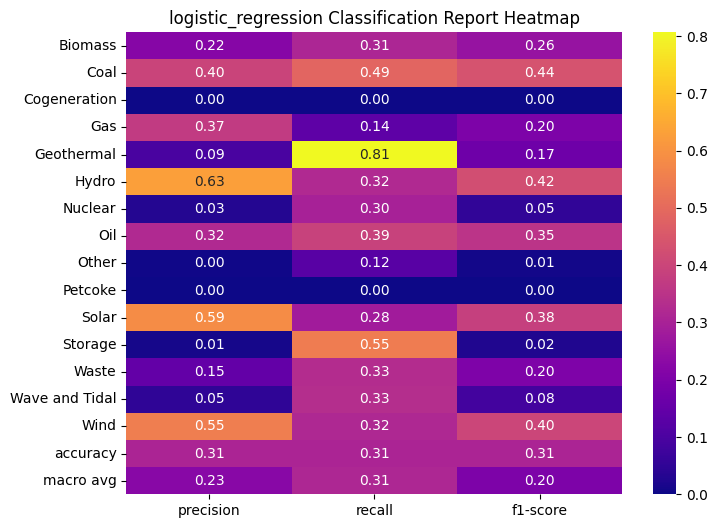

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


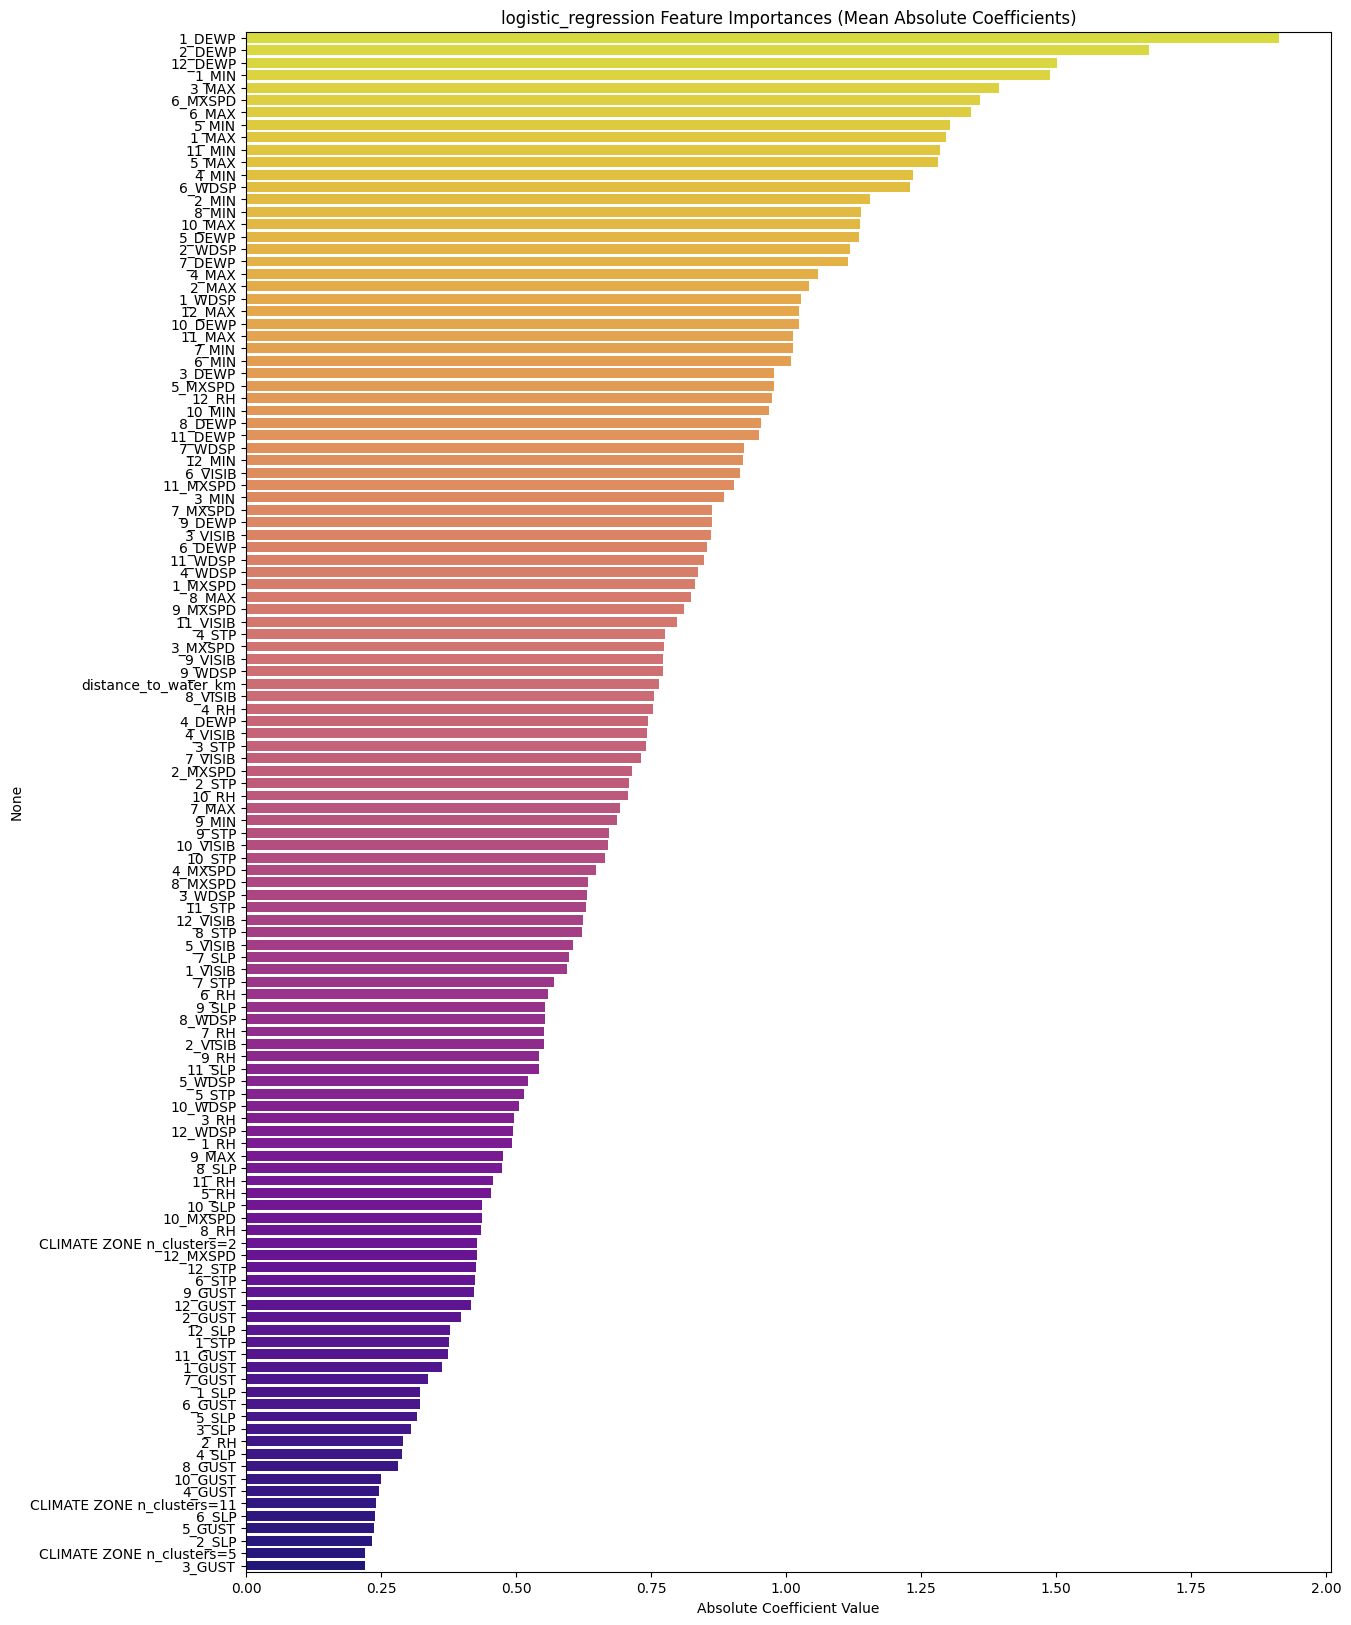

Evaluating random_forest model.


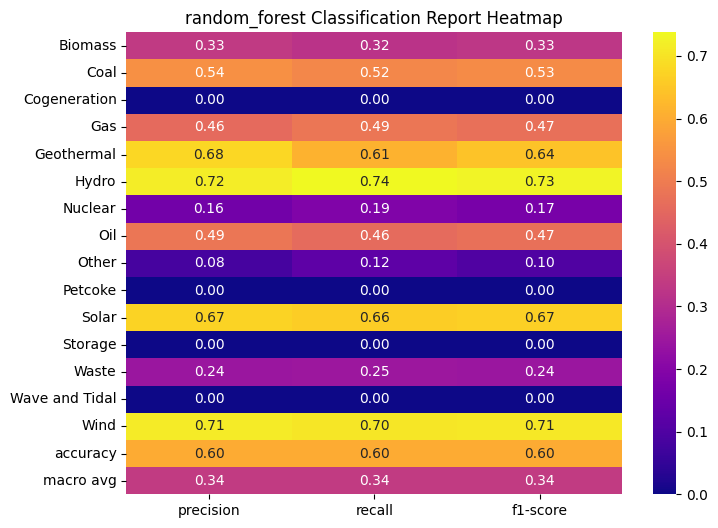

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


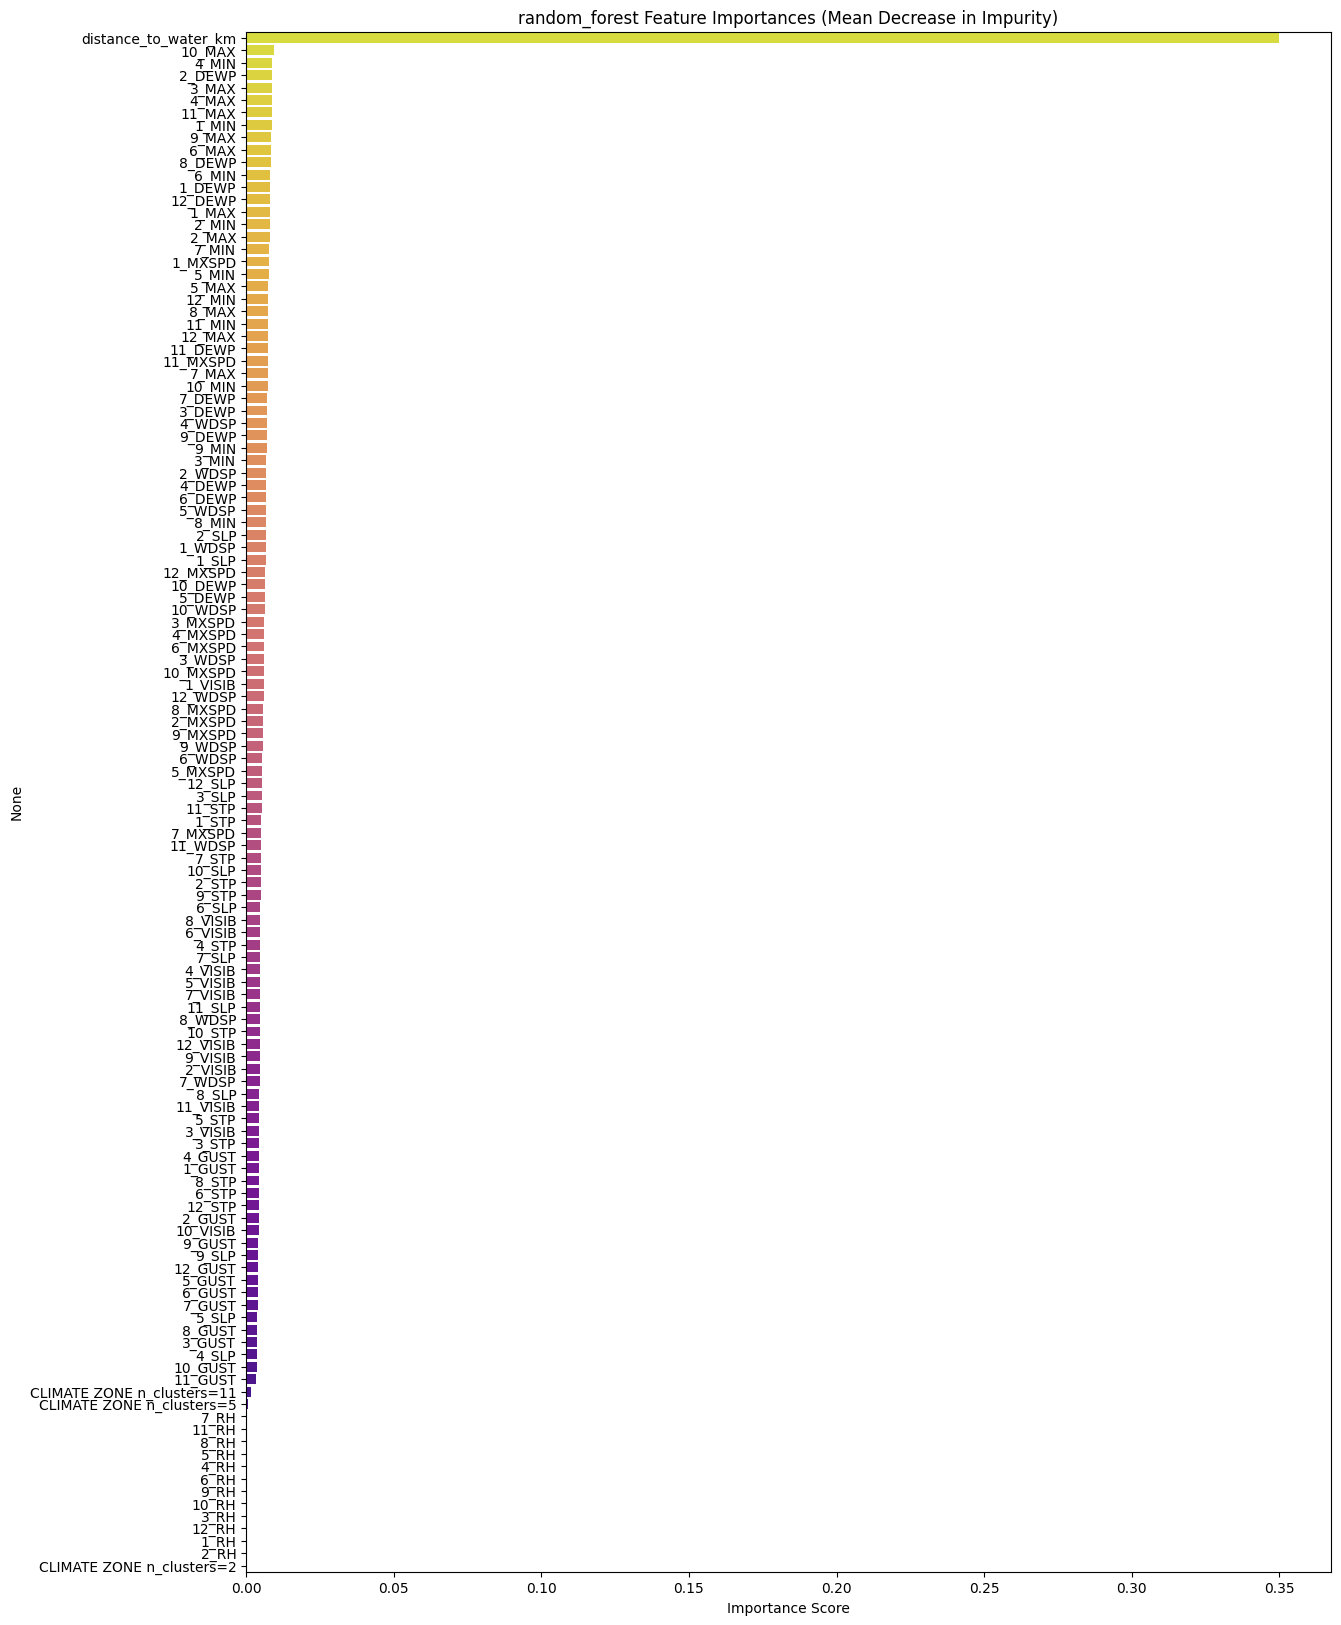

Evaluating decision_tree model.


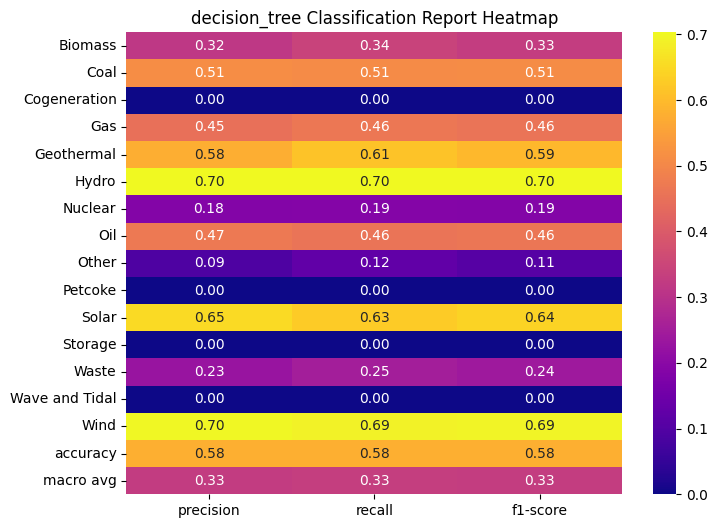

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


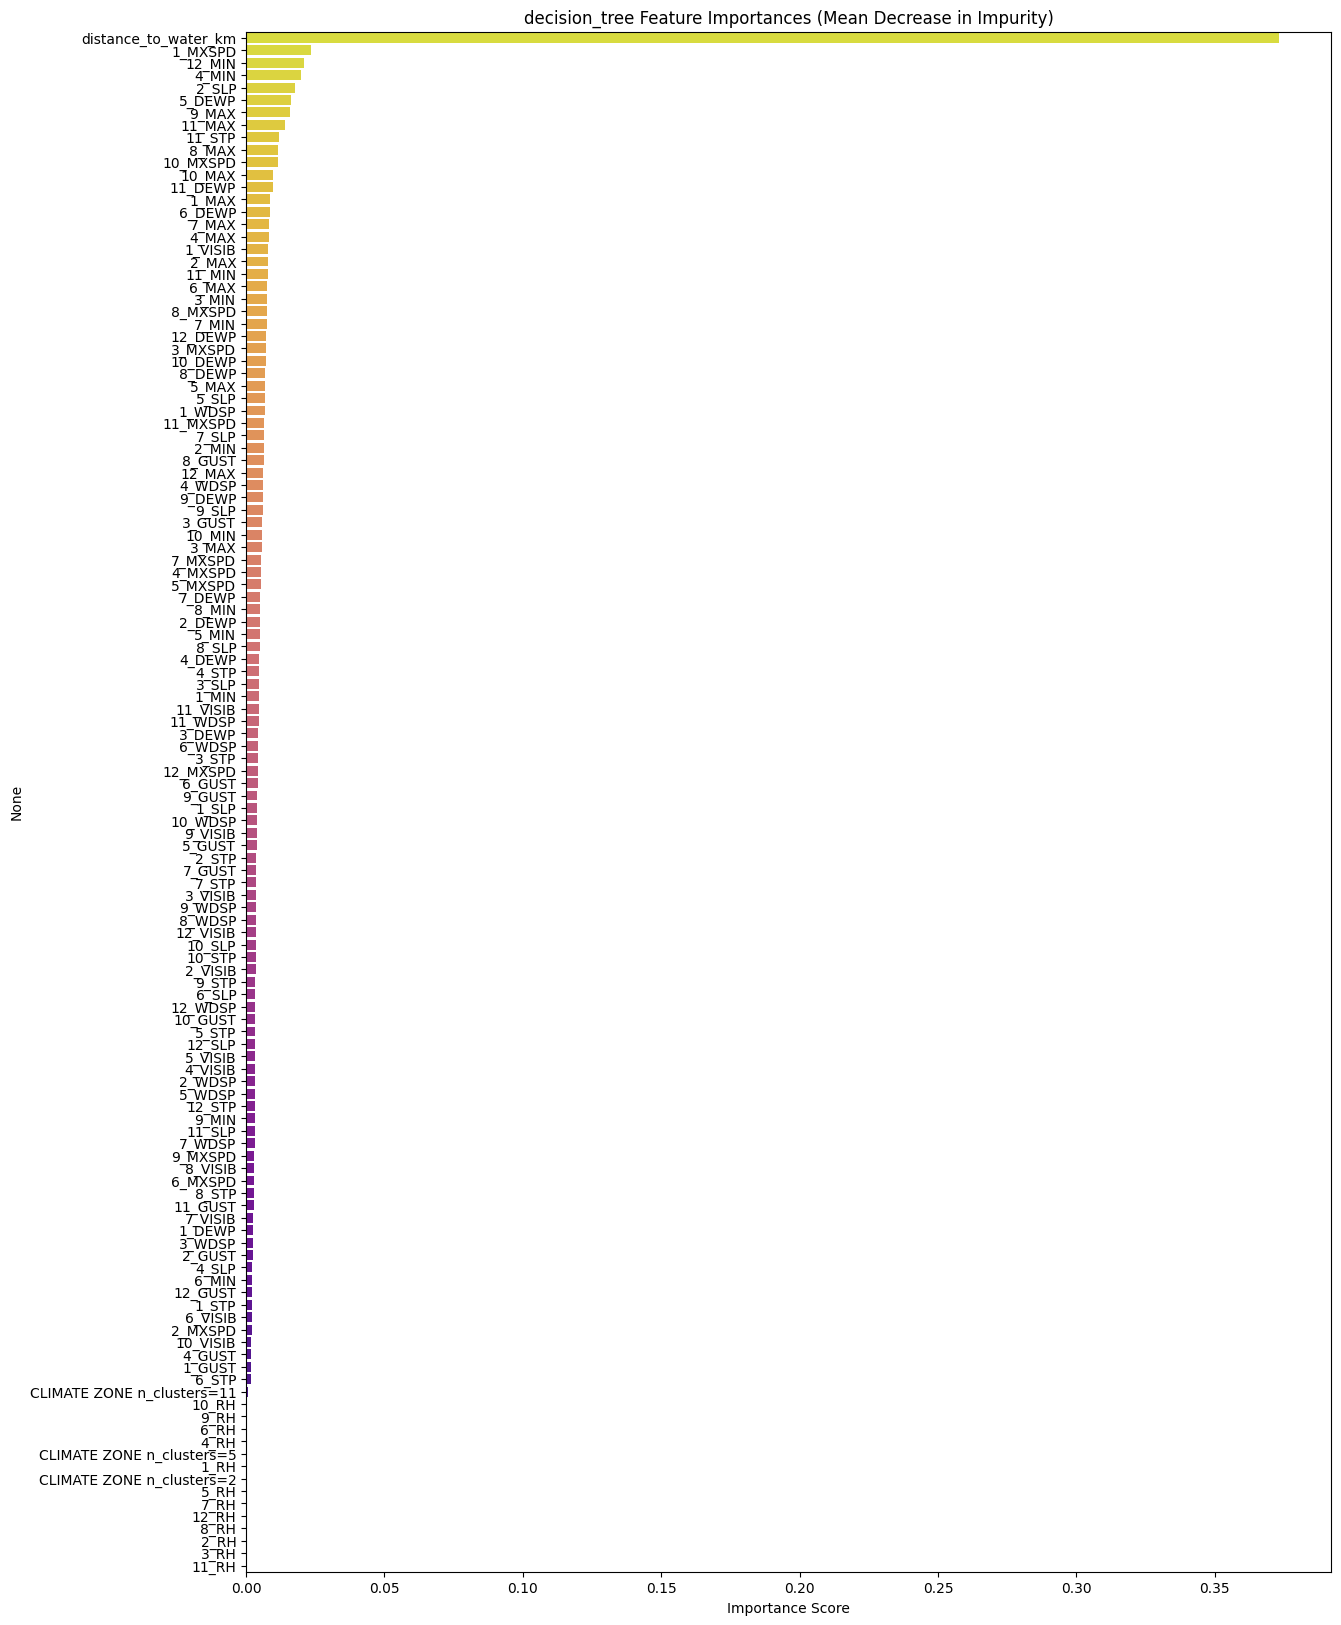

Without engineered feature.
Evaluating logistic_regression model.


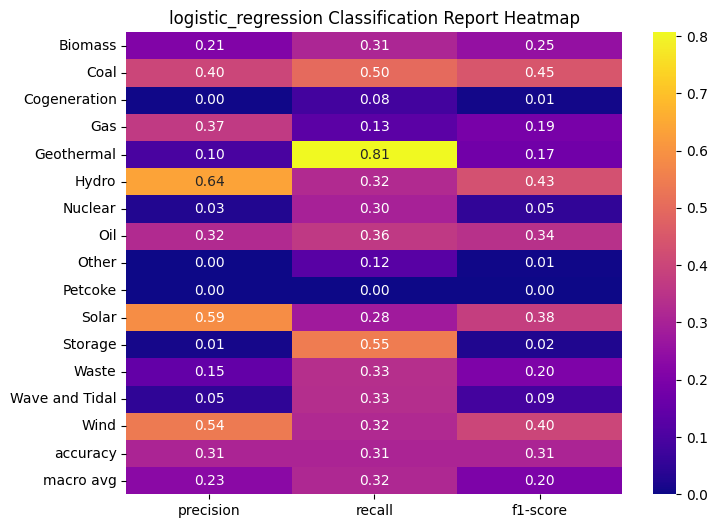

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


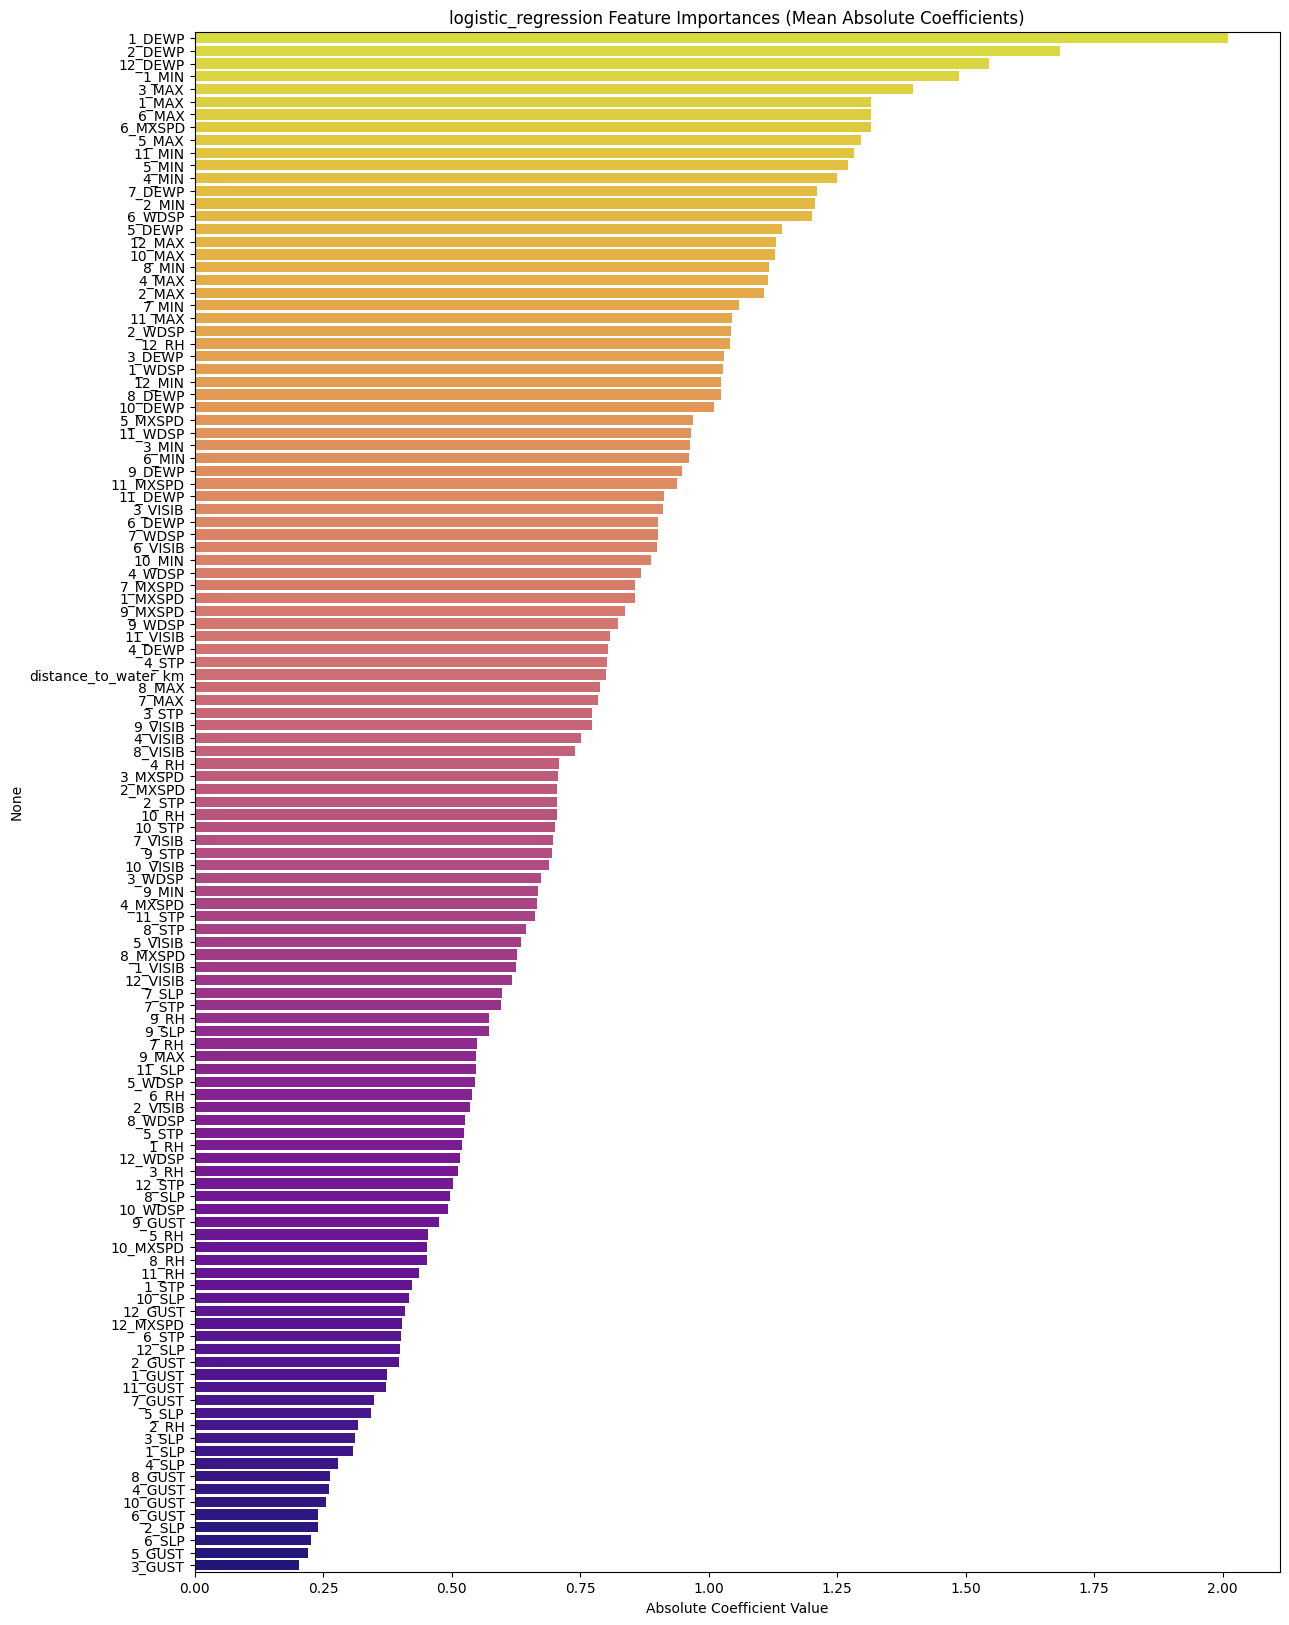

Evaluating random_forest model.


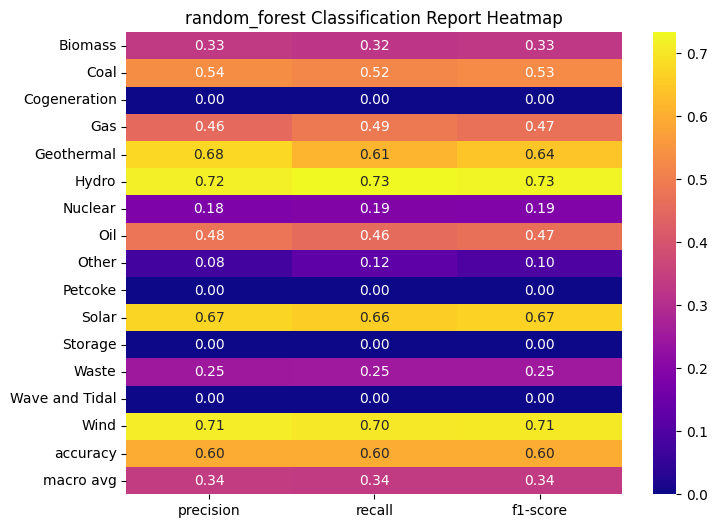

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


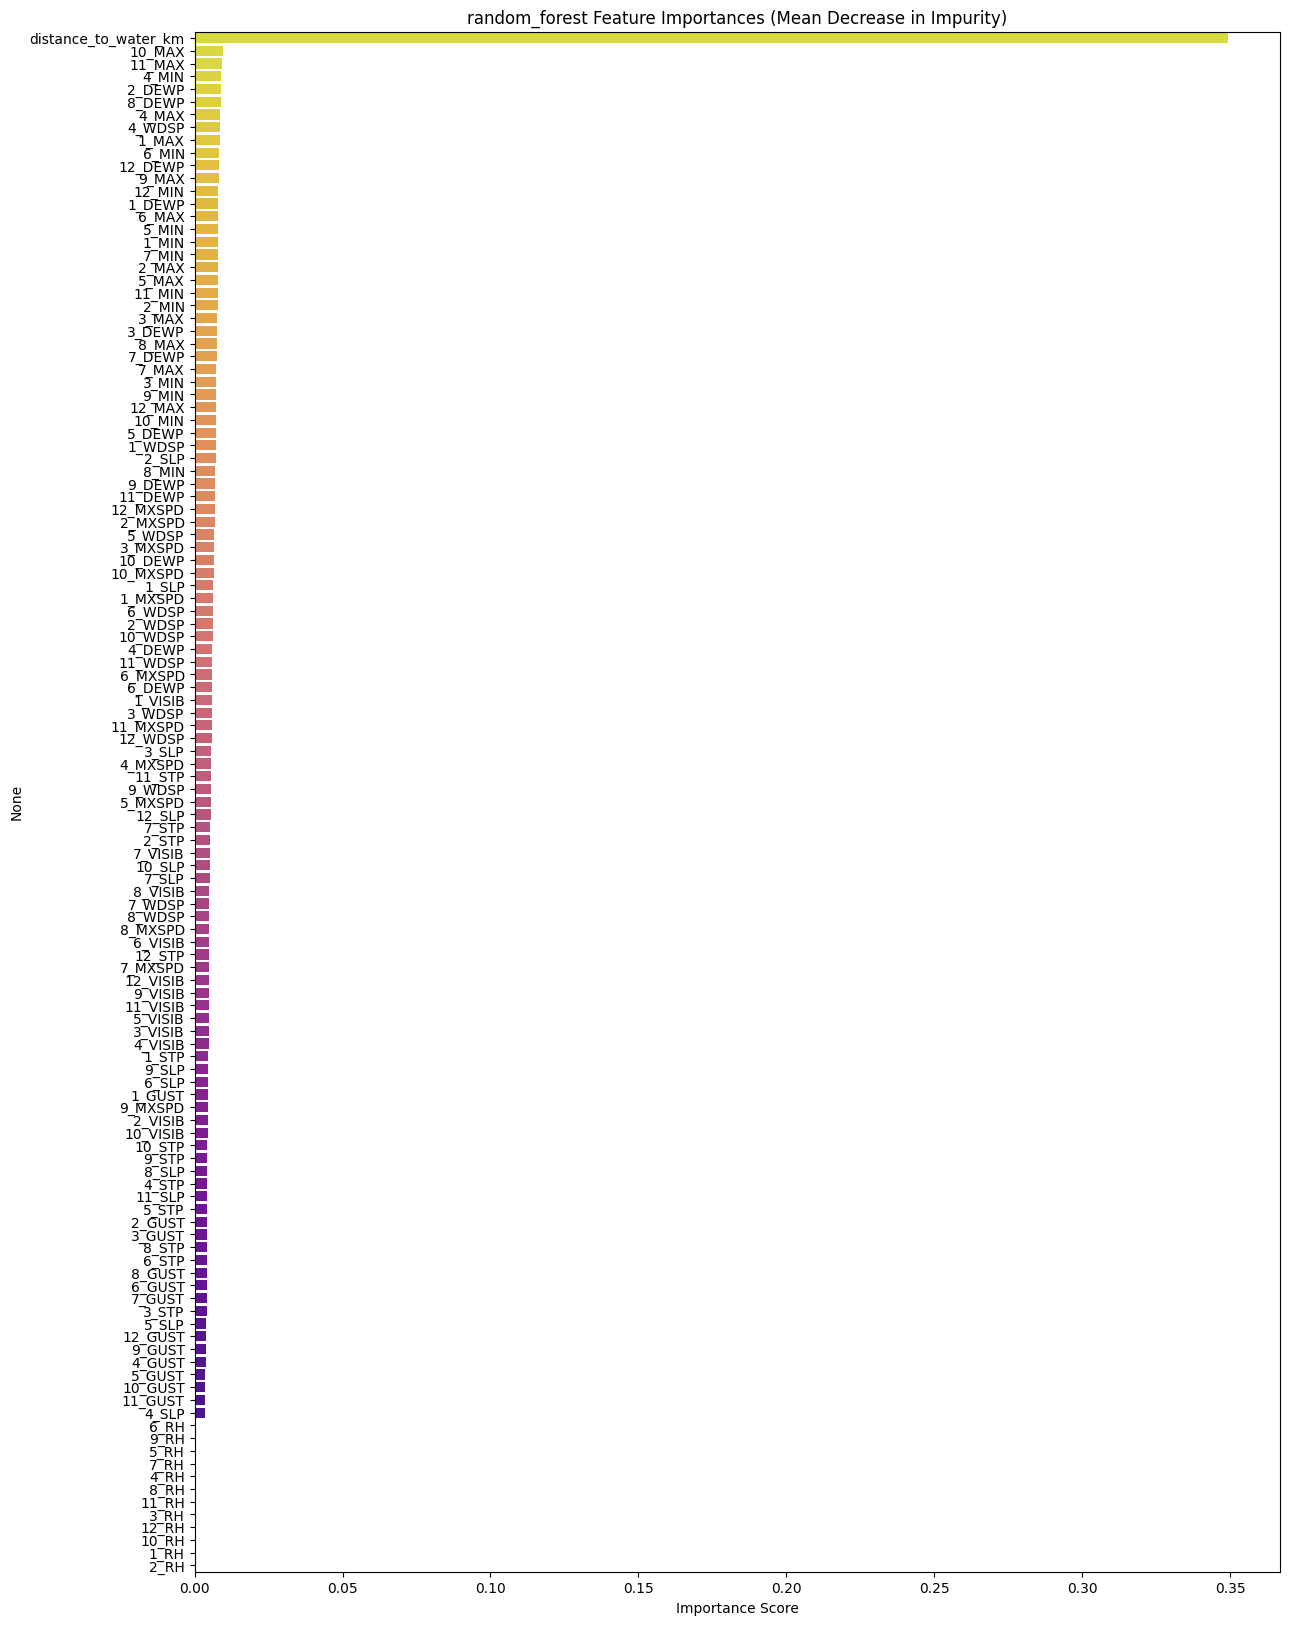

Evaluating decision_tree model.


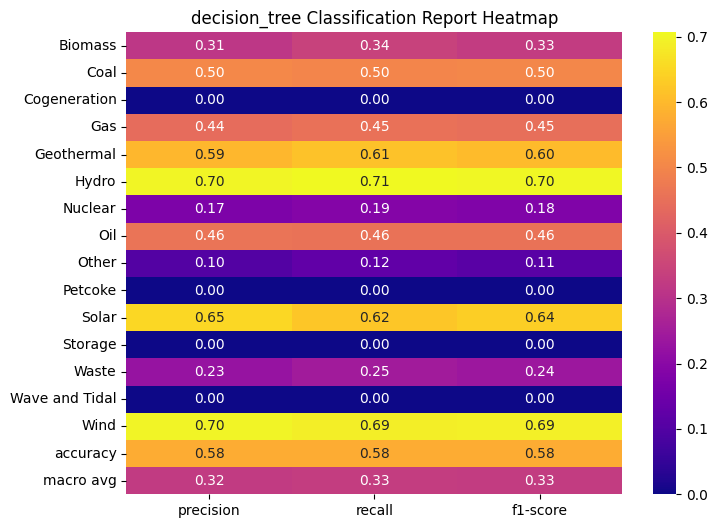

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


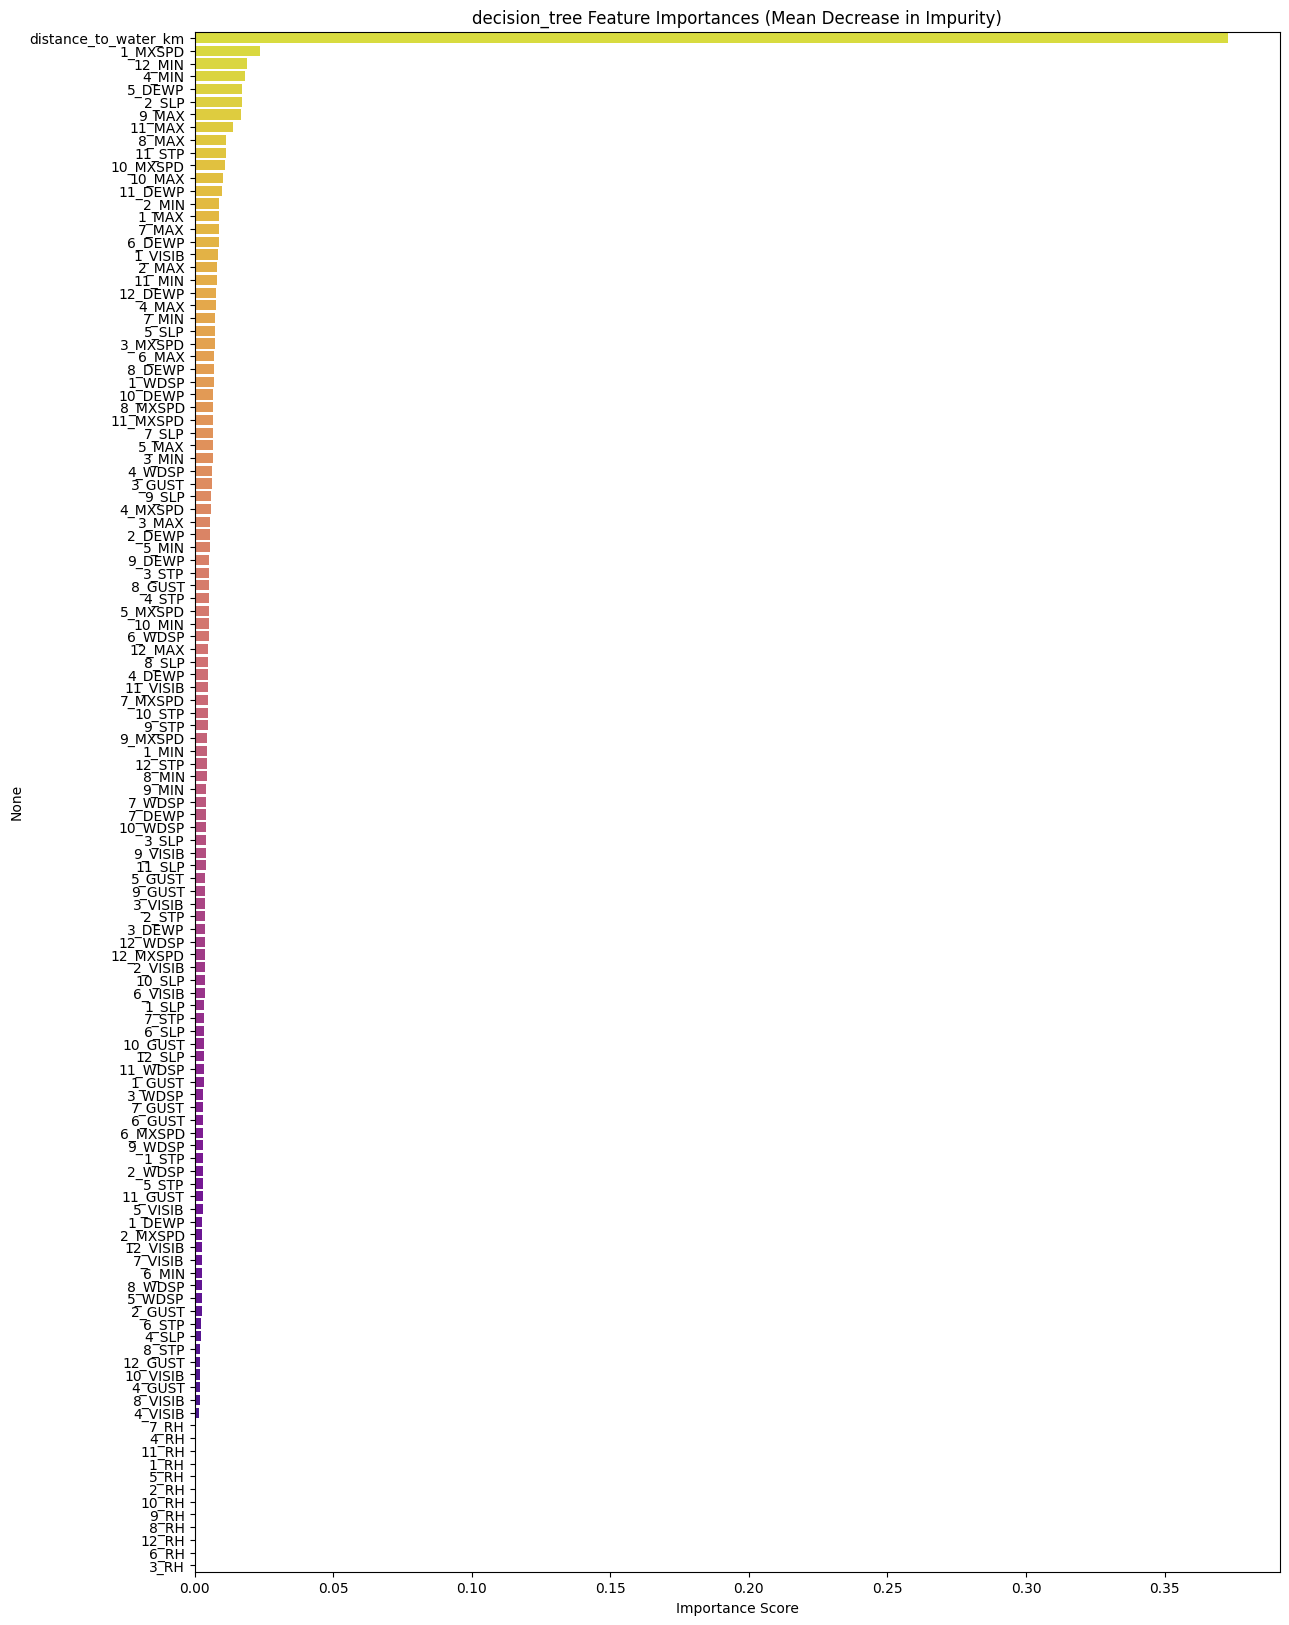

In [26]:
y = numeric_merged_df['Primary Fuel']

X = numeric_merged_df[numeric_features_full].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"With engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=True)
                                   
    models[key]['evaluation_metrics_w_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

for k in k_values:
    del X_train[f"CLIMATE ZONE n_clusters={k}"]
    
    del X_test[f"CLIMATE ZONE n_clusters={k}"]
    
print(f"Without engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=True)

With engineered feature.
Evaluating logistic_regression model.


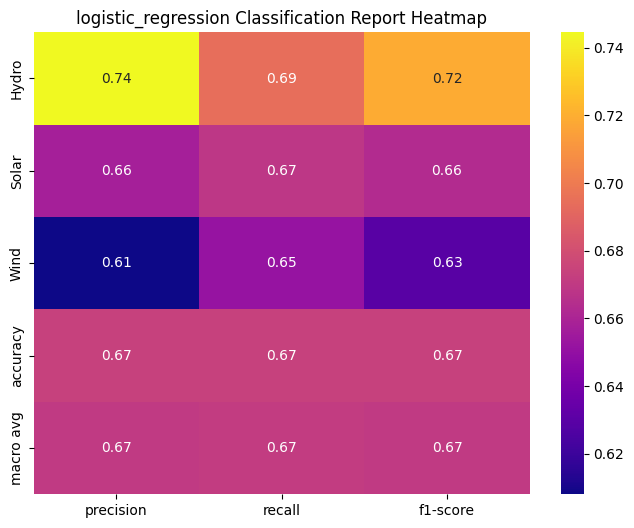

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


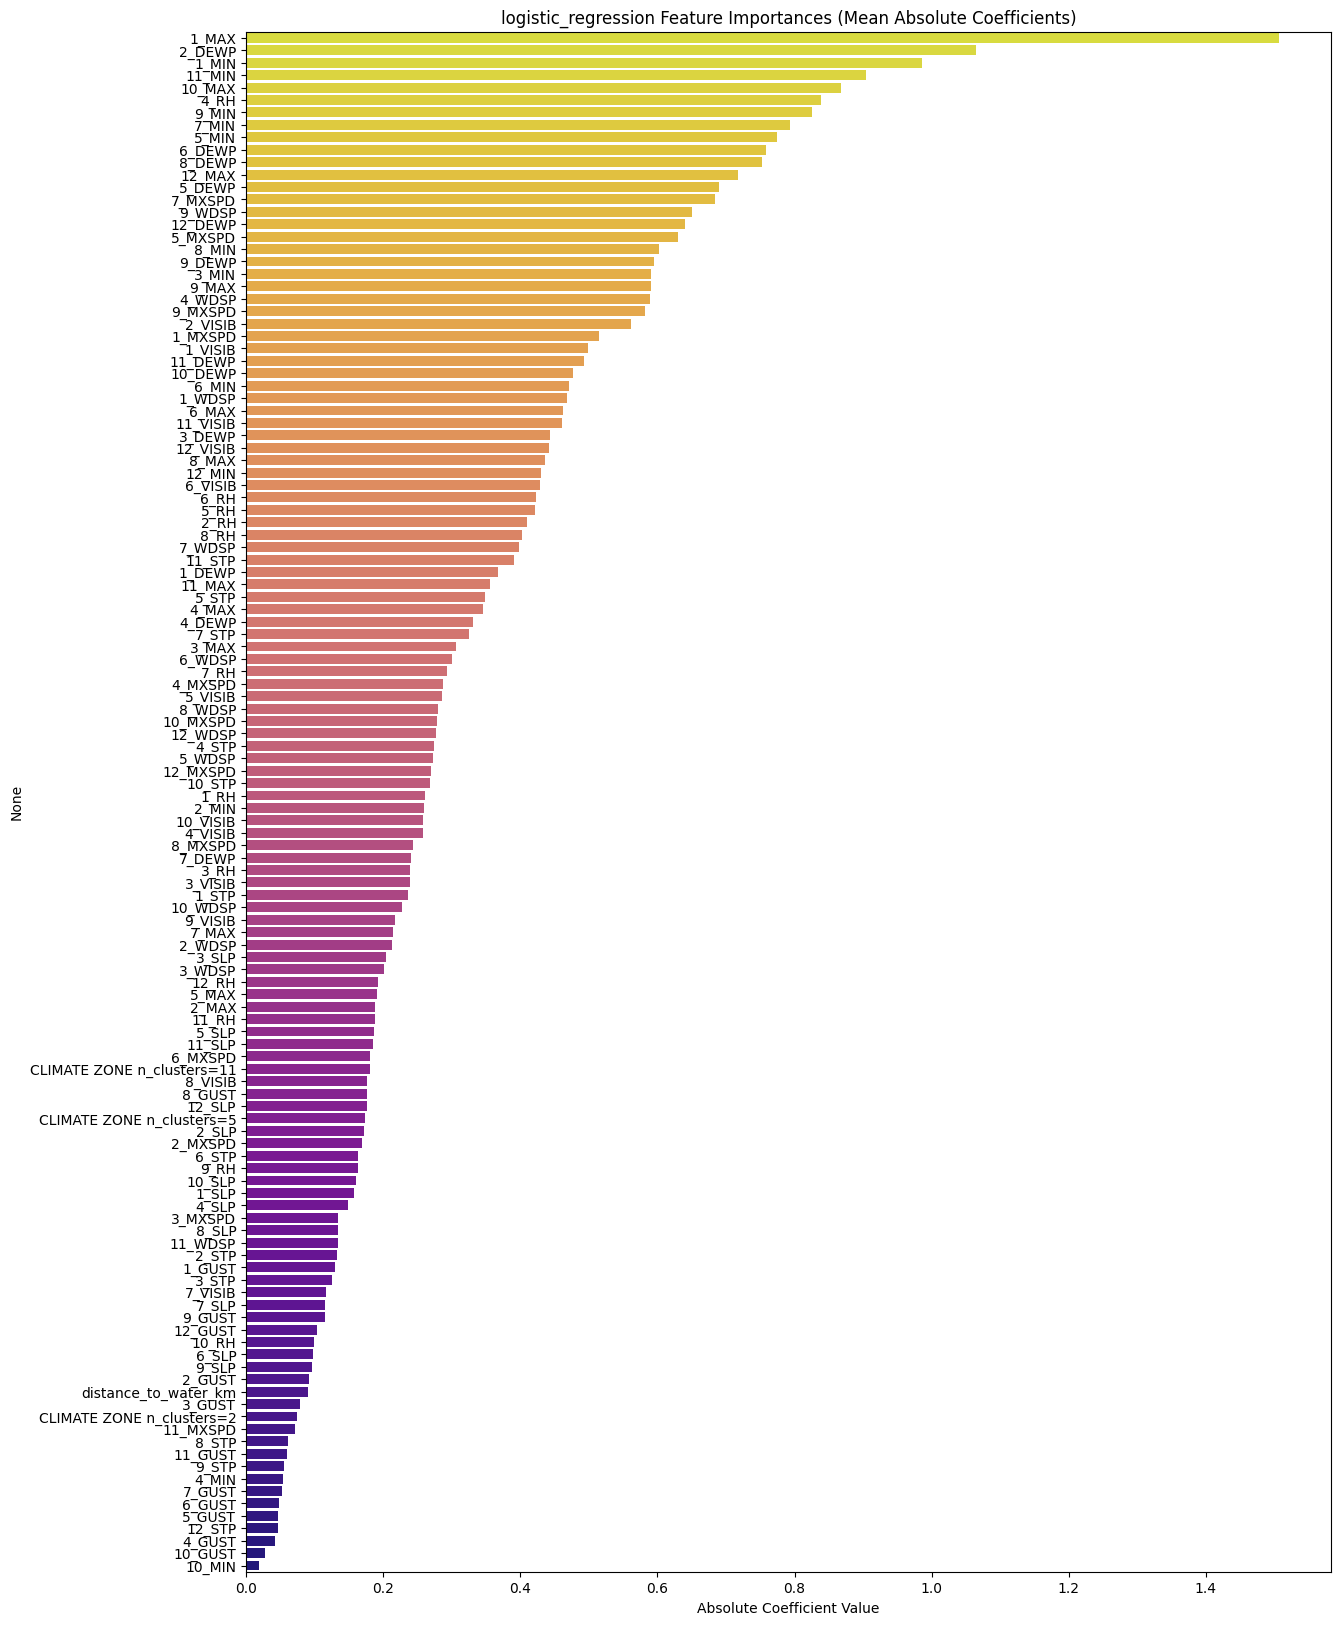

Evaluating random_forest model.


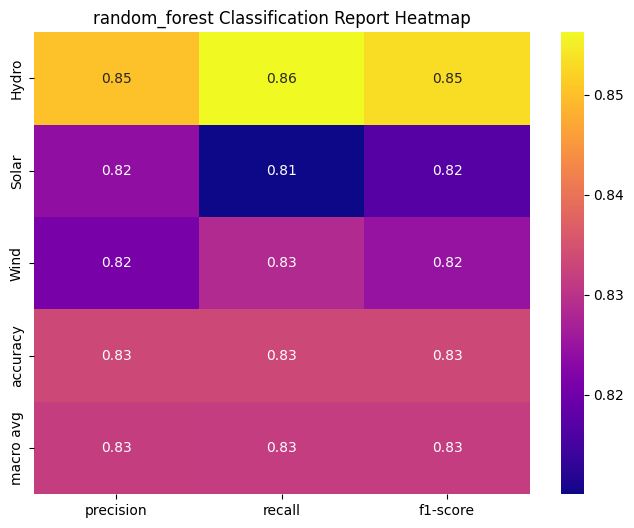

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


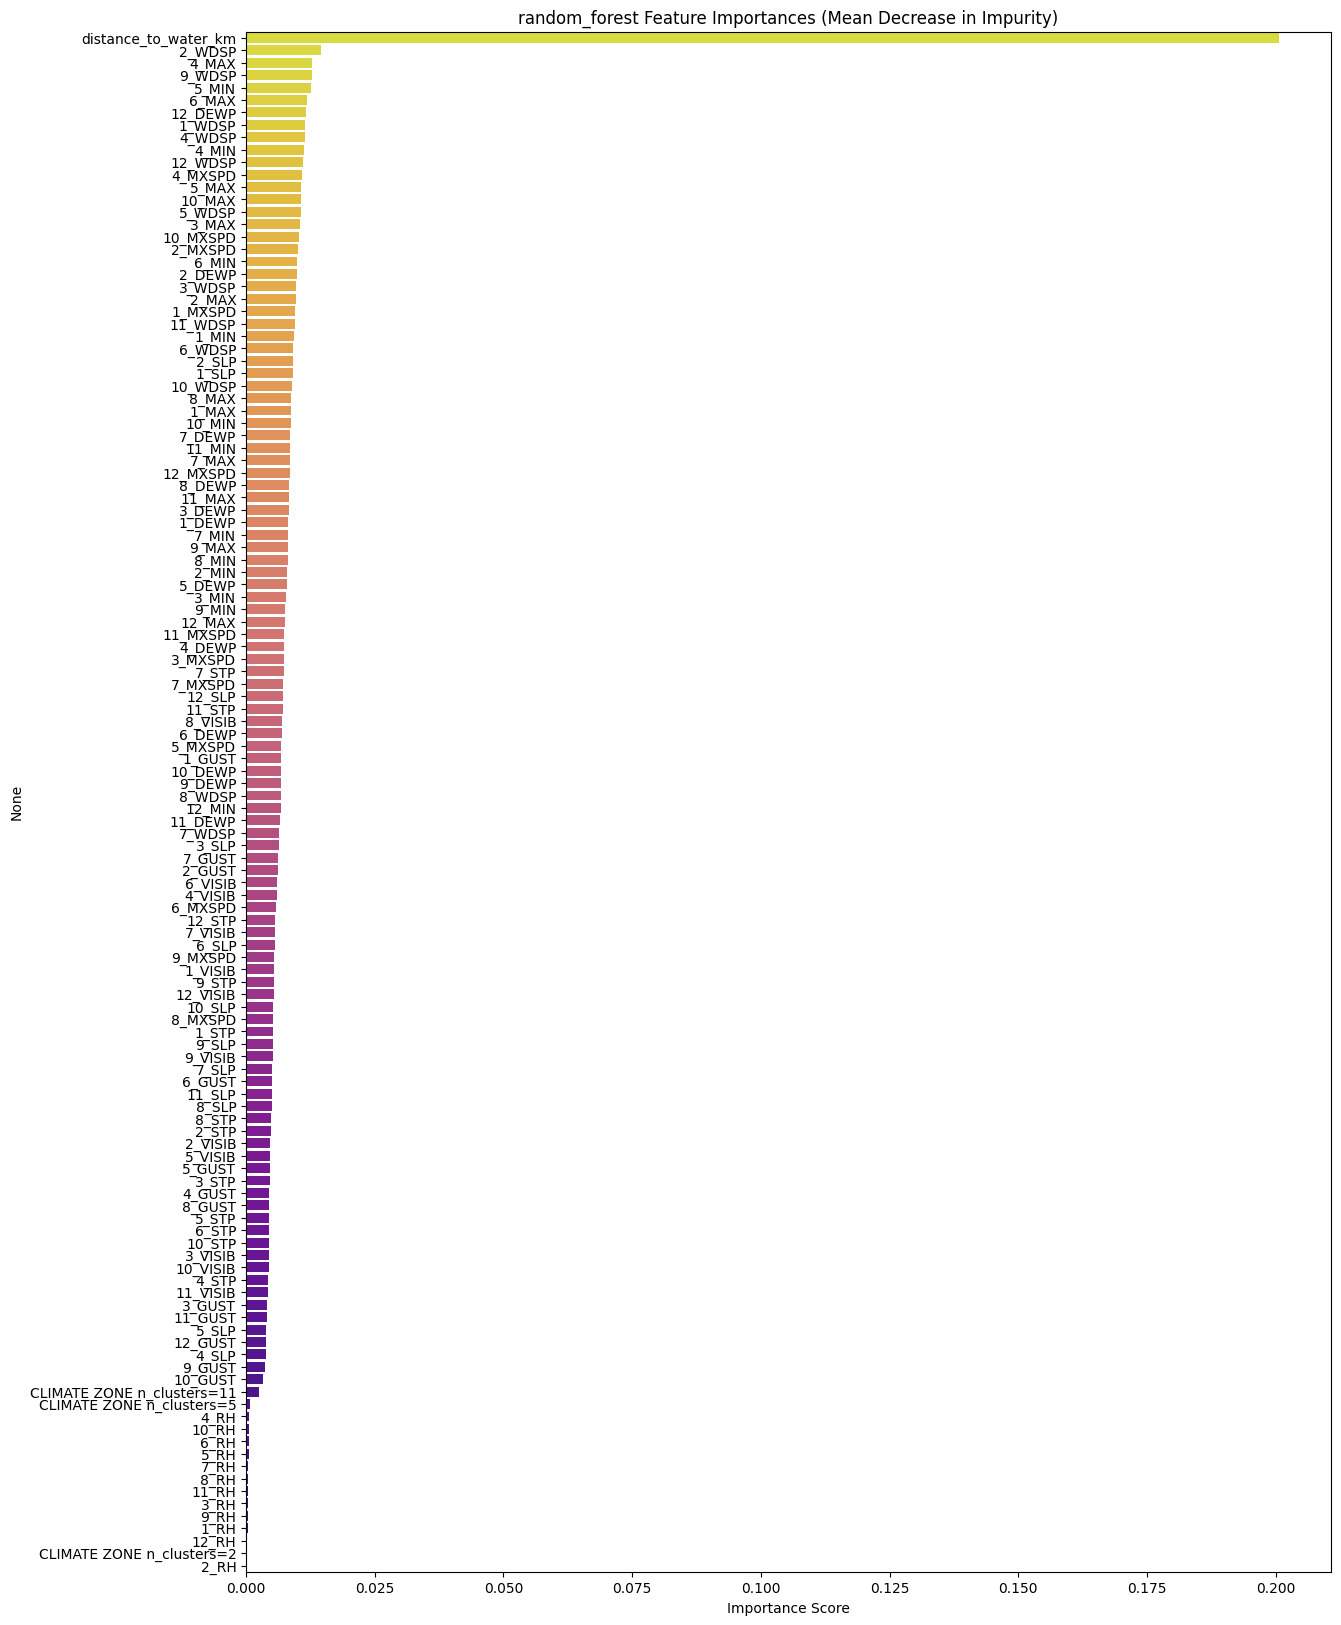

Evaluating decision_tree model.


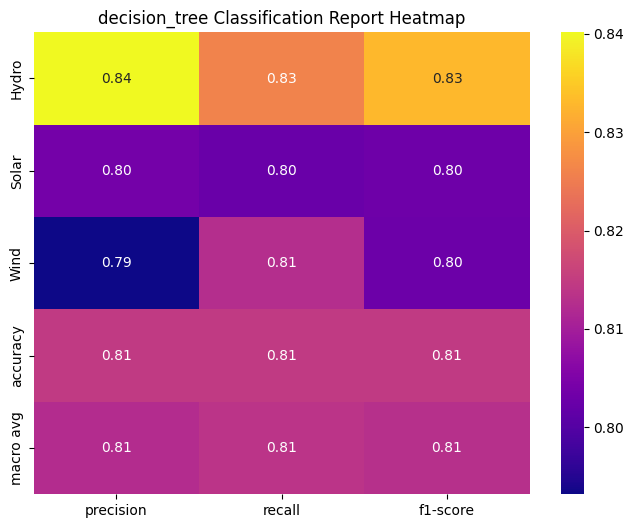

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


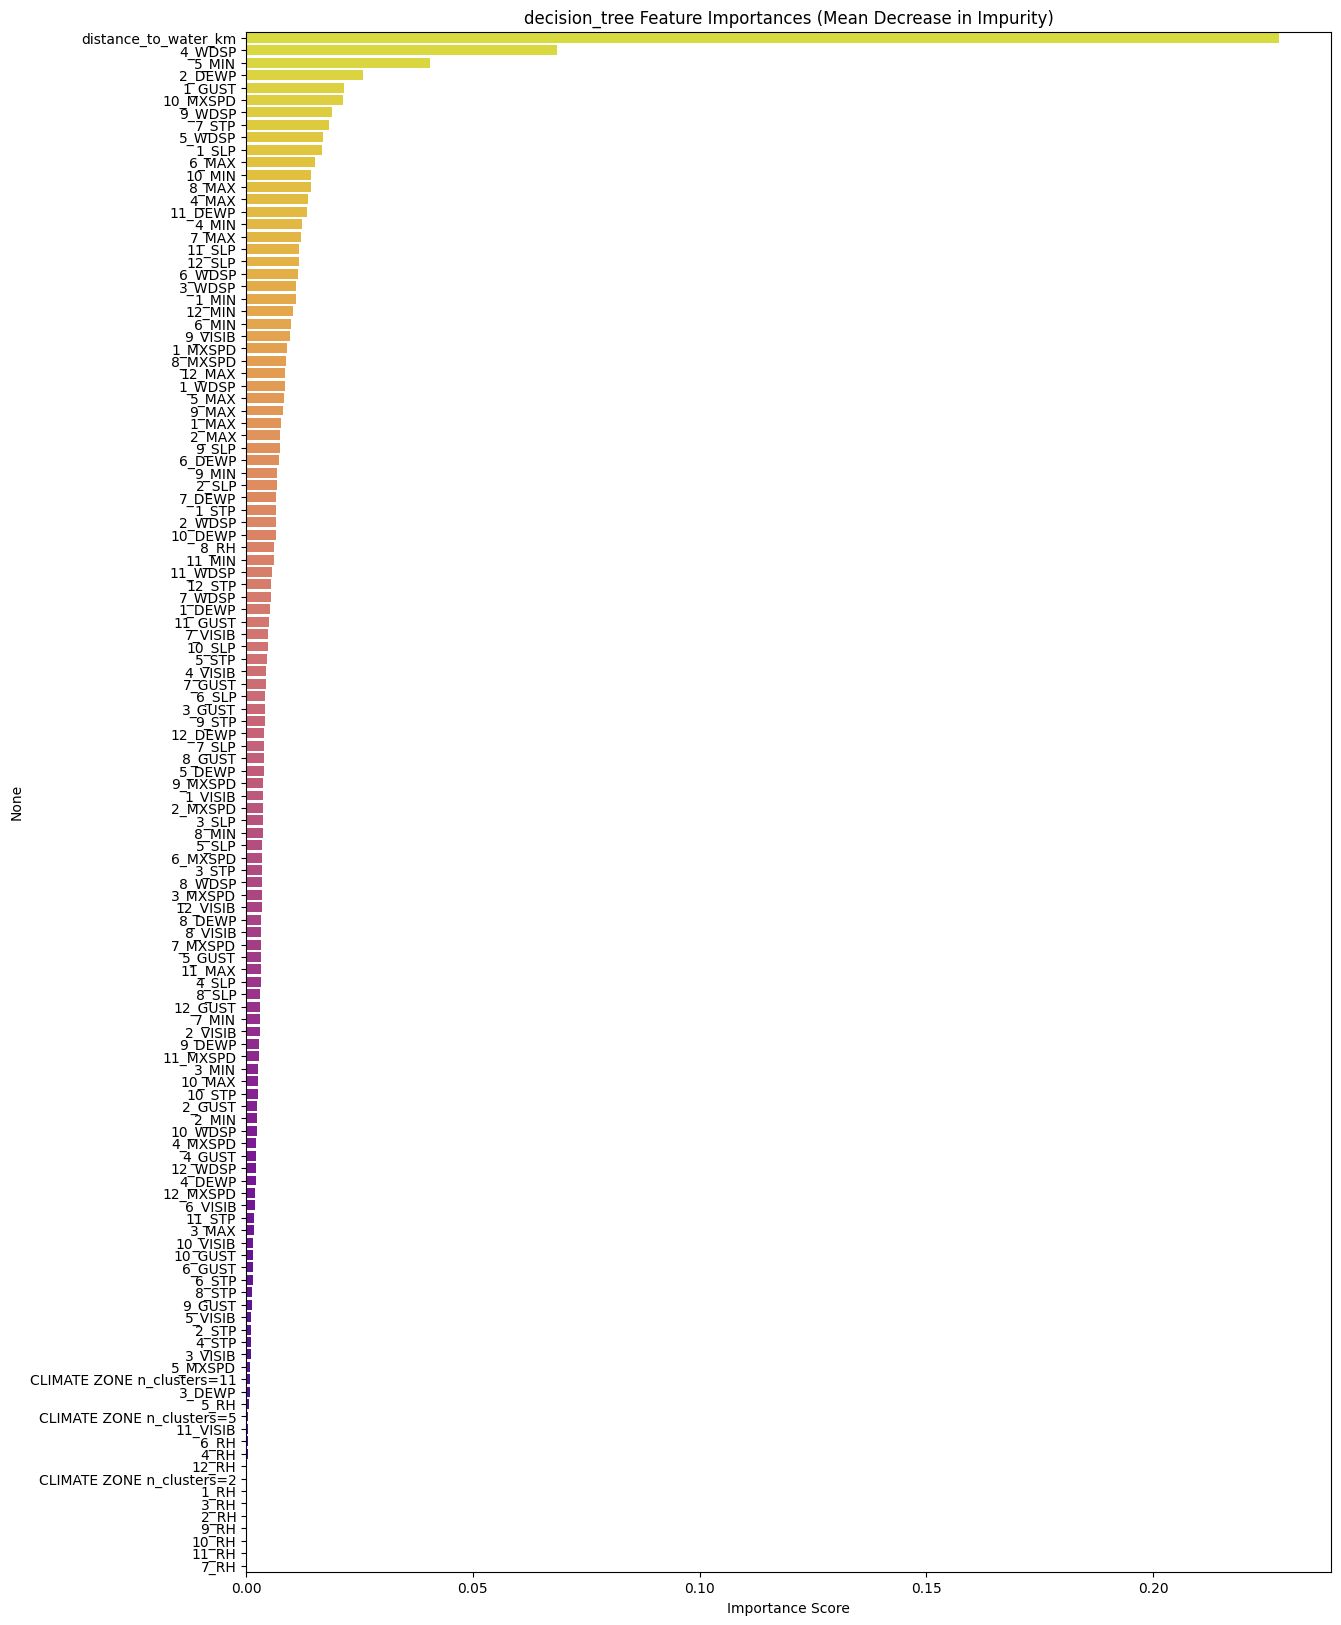

Without engineered feature.
Evaluating logistic_regression model.


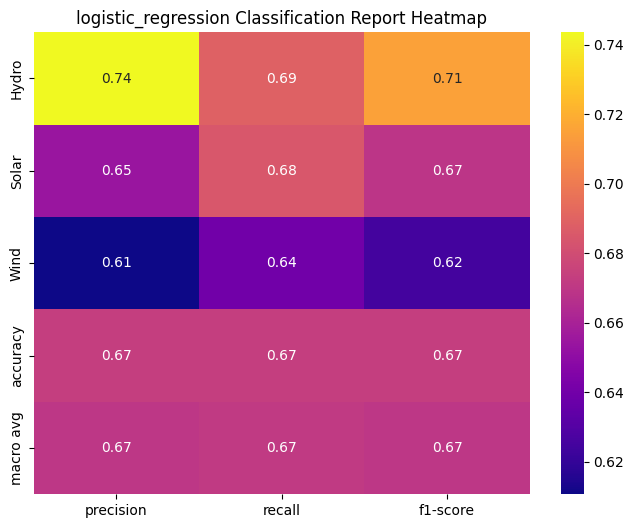

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


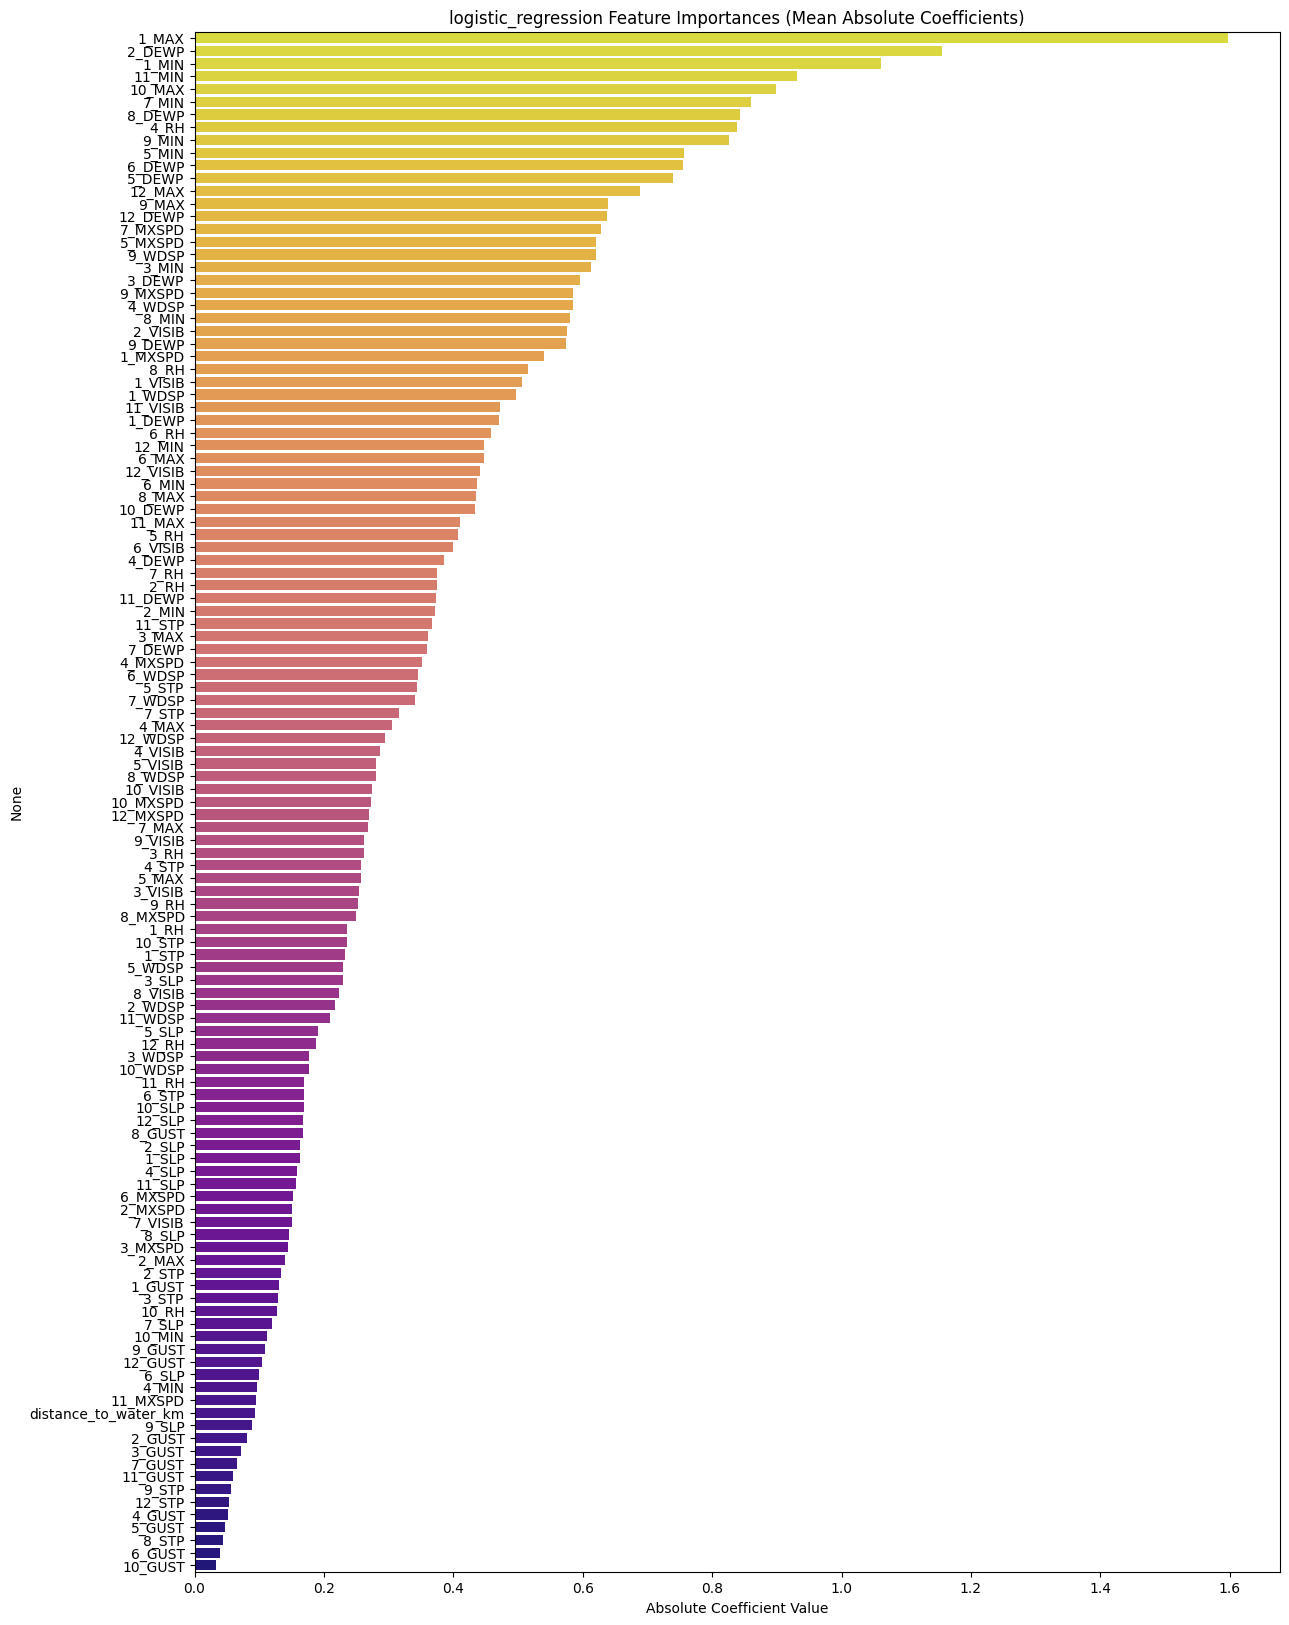

Evaluating random_forest model.


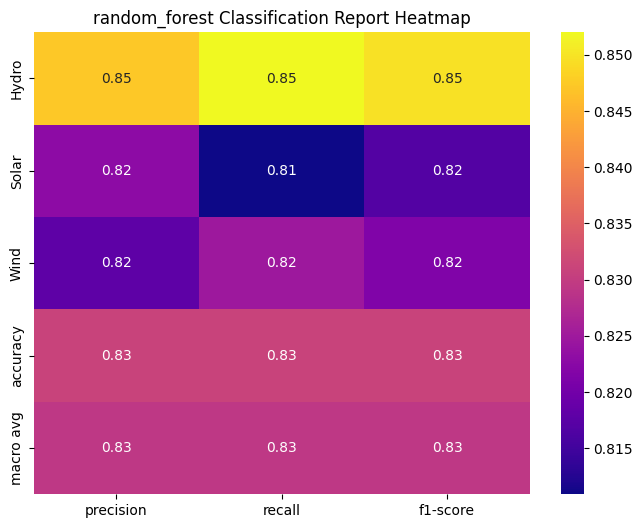

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


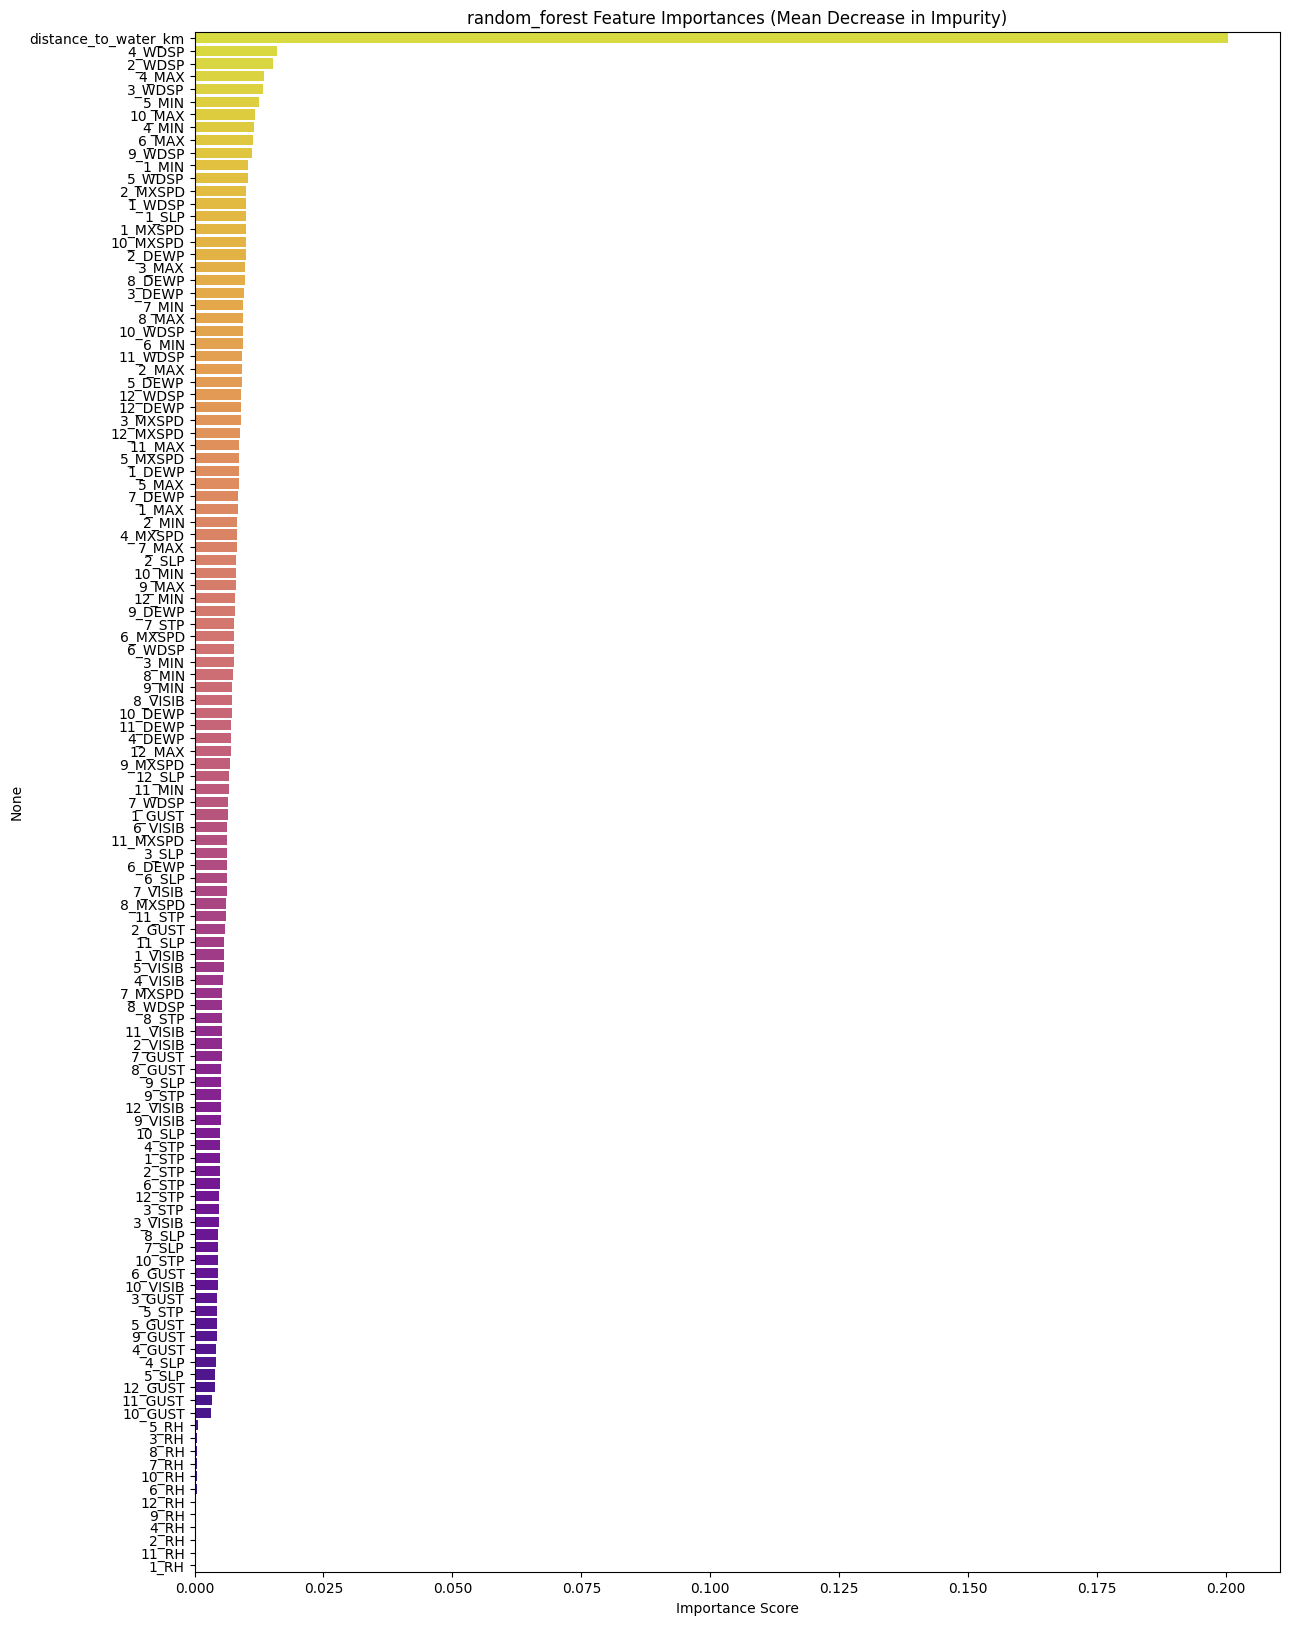

Evaluating decision_tree model.


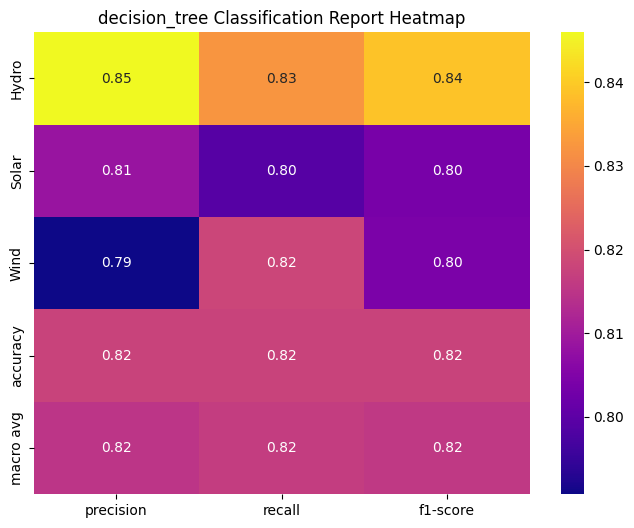

/var/folders/gl/919514x5085c7h3zzn_f471w0000gp/T/ipykernel_37455/3742966418.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='plasma_r')


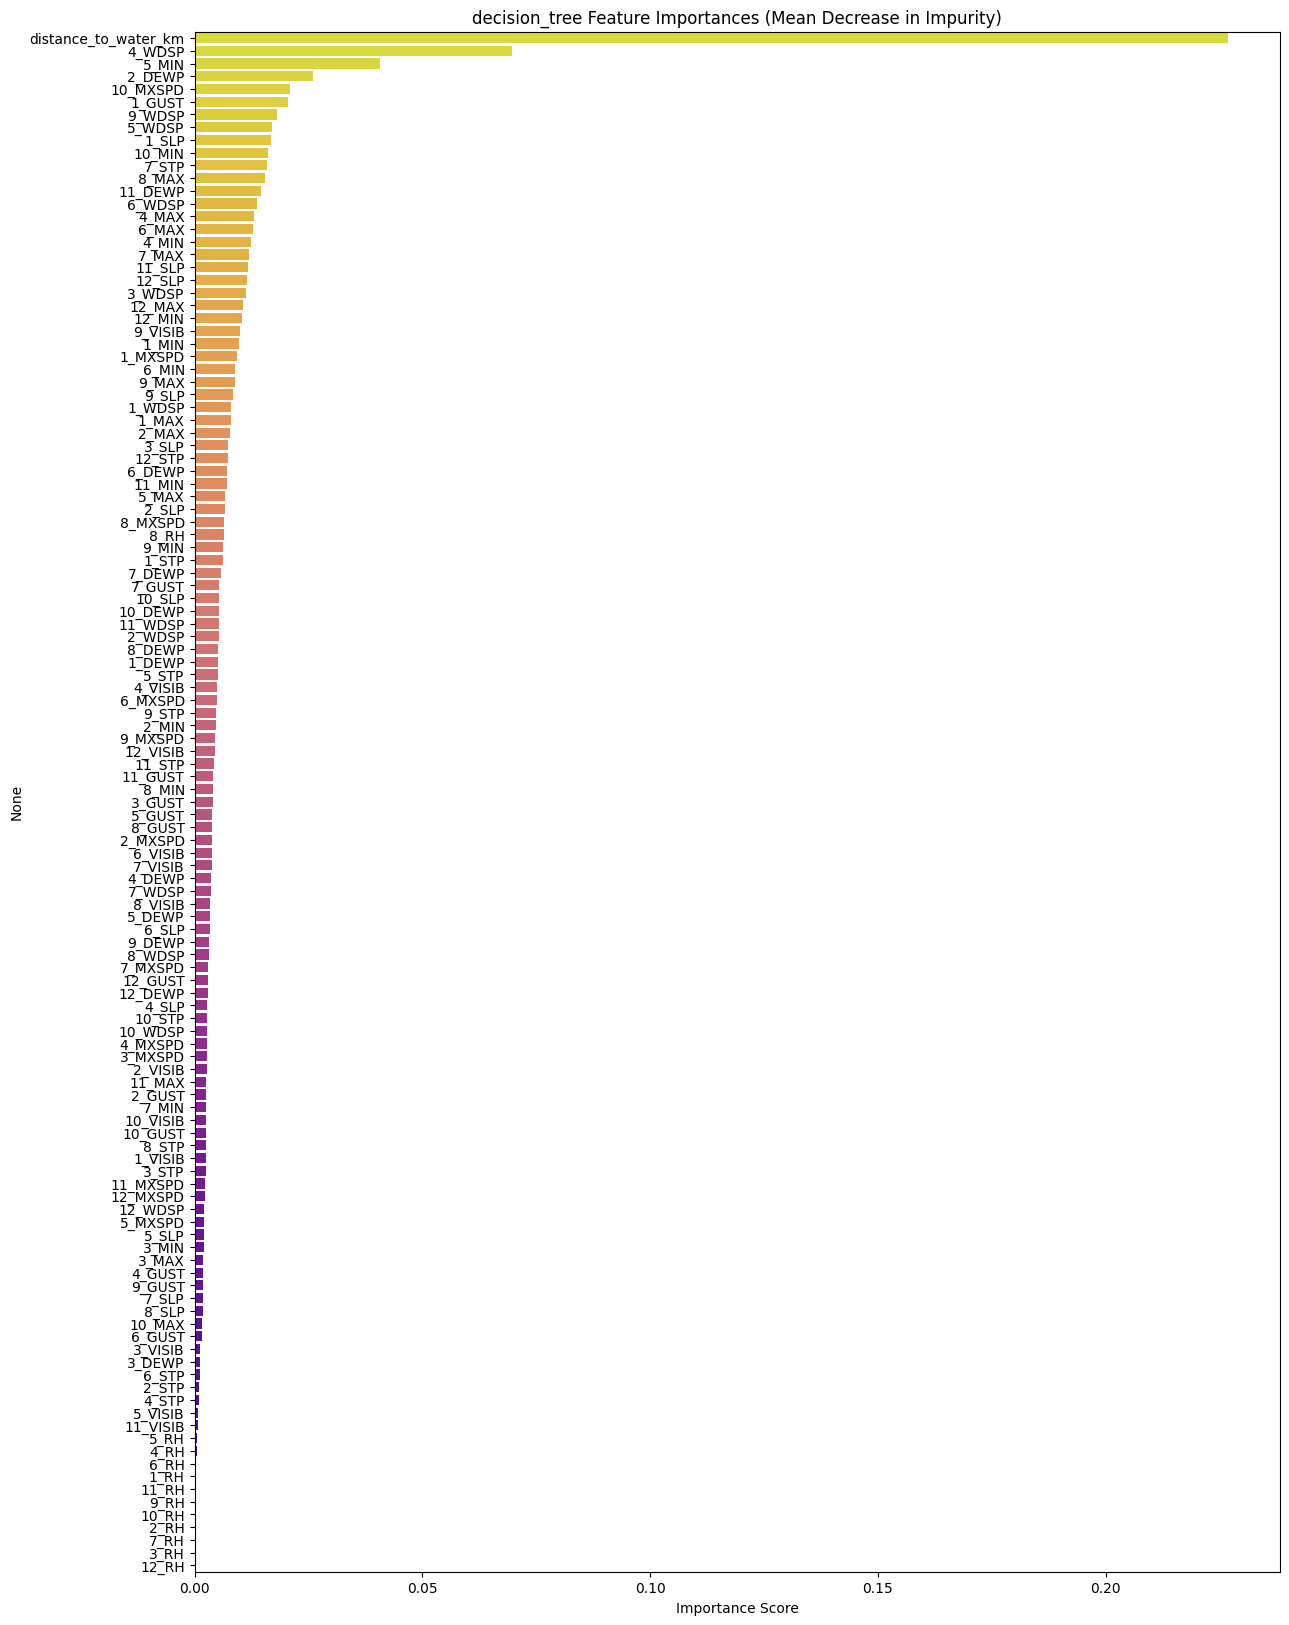

In [27]:
renewables_df = numeric_merged_df.copy()

renewables_df = renewables_df[renewables_df['Primary Fuel'].isin(['Solar','Wind','Hydro'])]

y = renewables_df['Primary Fuel']

X = renewables_df[numeric_features_full].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"With engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=True)
                                   
    models[key]['evaluation_metrics_w_ef'] = [accuracy_score, precision_score, recall_score, f1_score]

for k in k_values:
    del X_train[f"CLIMATE ZONE n_clusters={k}"]
    
    del X_test[f"CLIMATE ZONE n_clusters={k}"]
    
print(f"Without engineered feature.")
for key, value in models.items():
    print(f"Evaluating {key} model.")
    
    accuracy_score, precision_score, recall_score, f1_score = run_model(key,
                                                                        models[key]['model'],
                                                                        X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        build_plot=True)

What I really want to talk about or communicate about is the main goal of the project: determining regions of the world that are underserved by electrification. There is a map in Section 1 with global population vs. power plant capacity, and some iterations. This establishes motivation for the research and exploration. The question posed in the project goal - does a certain terrain or geography lend itself to a specific type of power plant - can be answered with the above classification reports. For renewables, there is a relationship between terrain and type of power plant, to the extent that the predictions are close to and over 80% accuracy. For all other power plants, energy density is a consideration, and what we observe is that proximity to water is an important feature. This makes sense, given the need to have cooling water in a heat engine and water for a hydro plant.








In [28]:
numeric_merged_df.columns

Index(['Powerplant Name', 'Capacity (MW)', 'Primary Fuel', 'Owner', 'Source',
       'distance_to_water_km', 'Longitude', 'Latitude', 'NAME', '1_TEMP',
       ...
       '3_RH', '4_RH', '5_RH', '6_RH', '7_RH', '8_RH', '9_RH', '10_RH',
       '11_RH', '12_RH'],
      dtype='object', length=162)

Build a map of terrain with expected energy capacity. It answers the question posed at the very beginning of the project.

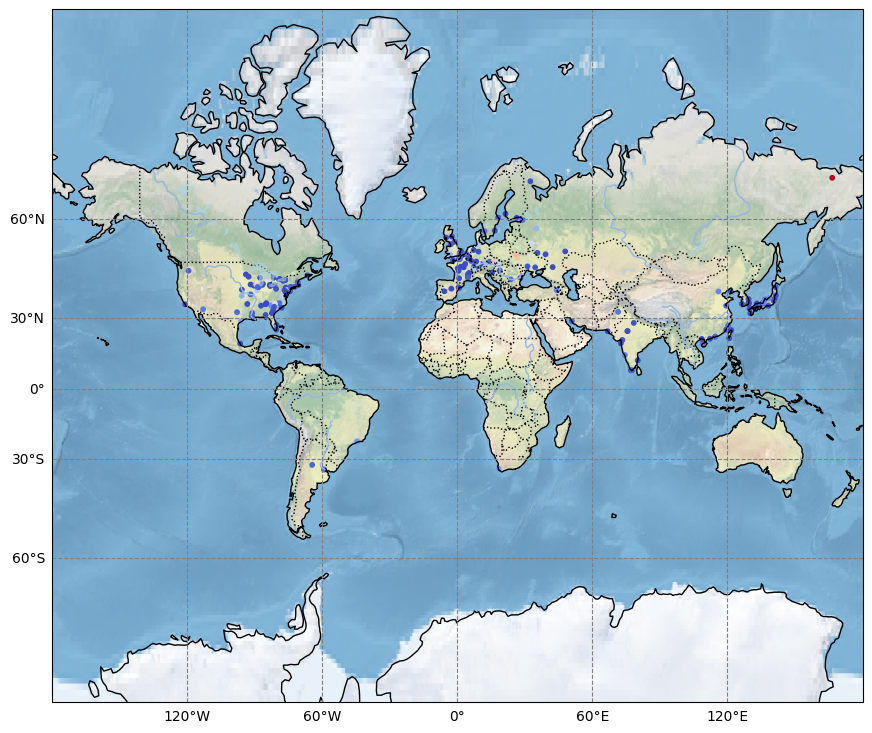

In [29]:
df = numeric_merged_df[['Powerplant Name',
                        'Primary Fuel',
                        'distance_to_water_km',
                        'Longitude',
                        'Latitude']][numeric_merged_df['Primary Fuel']=='Nuclear']

plot_map("",
         df['Longitude'],
         df['Latitude'],
         df['distance_to_water_km'],
         cmap='coolwarm',
         s=10)

In [30]:
df.sort_values('distance_to_water_km')

Powerplant Name Primary Fuel  distance_to_water_km  Longitude  \
17050                  Chinshan      Nuclear              0.000000   121.5874   
7773               Laguna Verde      Nuclear              0.000000   -96.4064   
8115               Browns Ferry      Nuclear              0.000000   -87.1189   
17739                Oskarshamn      Nuclear              0.000000    16.6683   
17516                    Kanupp      Nuclear              0.000000    66.7888   
...                         ...          ...                   ...        ...   
9896   Byron Generating Station      Nuclear             70.740245   -89.2819   
20677                  Dukonavy      Nuclear             74.943120    16.1479   
18935               Khmelnytska      Nuclear             75.252558    26.6473   
18936             Rivne (Rouno)      Nuclear             79.885529    25.8974   
18597                  Bilibino      Nuclear            120.758230   166.5389   

       Latitude  
17050   25.2861  
7773    19.7208  
8115    34.7042  
17739   57.4130  
17516   24.8450  
...         ...  
9896    42.0742  
20677   49.0852  
18935   50.3024  
18936   51.3245  
18597   68.0503  

[198 rows x 5 columns]

Proximity to water is returned as the most important variable per the random_forest and decision_tree models. This makes sense. The distance_to_water_km feature developed from geopandas was inaccurate. A manual verification of some of the power plants verified distance to water to be mostly zero for all of the power plants that utilize a heat cycle, as well as hydro. It is common sense that hydro and heat cycles need would be close to sources of water. The Almirante Álvaro Alberto - Units I and II are literally located on the South Atlantic Ocean, yet, geopandas returns inaccurate data. Hinkley Point is located on the Atlantic ocean as well: 

<br><br><br><h4>Angra Nuclear Power Plant</h4>
<div style="display: flex; justify-content: center; gap: 5px;">
    <img src='imgs/Around_Paraty,_Brazil_2018_239.jpg' alt="Description 1" style="width: 48%; height: auto;">
    <img src="imgs/algara_nuke.png" alt="Description 2" style="width: 48%; height: auto;">
</div>
<br><br><br><h4>Hinkley Point</h4>
<div style="display: flex; justify-content: center; gap: 5px;">
    <img src='imgs/Hinkley_Point_B_power_stationas_seen_from_beach.jpg' alt="Description 1" style="width: 48%; height: auto;">
    <img src='imgs/hinkley_nuke.png' alt="Description 2" style="width: 48%; height: auto;">
</div>

In [31]:
numeric_merged_df['Primary Fuel'].unique()

array(['Other', 'Coal', 'Oil', 'Gas', 'Wind', 'Nuclear', 'Hydro', 'Solar',
       'Waste', 'Biomass', 'Wave and Tidal', 'Petcoke', 'Cogeneration',
       'Geothermal', 'Storage'], dtype=object)

I've worked in a nuclear power plant before and I'm aware of how ridiculous it would be to not have a source of water, so, I'm manually editing this dataset to set proximity to water at 0.0km. I haven't worked at other types of plants, so, an actual manual verification would be required. 

In [32]:
numeric_merged_df['distance_to_water_km'] = numeric_merged_df[numeric_merged_df['Primary Fuel']=='Nuclear']['distance_to_water_km'].apply(lambda x: 0.0)

In [33]:
numeric_merged_df[numeric_merged_df['Primary Fuel']=='Nuclear']

Powerplant Name  Capacity (MW)  \
19                                              ATUCHA I          370.0   
20                                             ATUCHA II          745.0   
84                                               EMBALSE          648.0   
682    Almirante Álvaro Alberto - Unidade I (Antiga A...          640.0   
683    Almirante Álvaro Alberto - Unidade II (Antiga ...         1350.0   
...                                                  ...            ...   
26470                                            Ling Ao         3914.0   
26471                                             Ningde         4072.0   
26472                                          Qinshan 2         4101.0   
26473                                            Tianwan         1980.0   
26474                                          Yangjiang         4000.0   

      Primary Fuel Owner                                         Source  \
19         Nuclear  NASA                Ministerio de Energía y Minería   
20         Nuclear  NASA                Ministerio de Energía y Minería   
84         Nuclear  NASA                Ministerio de Energía y Minería   
682        Nuclear     0  Agência Nacional de Energia Elétrica (Brazil)   
683        Nuclear     0  Agência Nacional de Energia Elétrica (Brazil)   
...            ...   ...                                            ...   
26470      Nuclear     0                                           IAEA   
26471      Nuclear     0                                           IAEA   
26472      Nuclear     0                                           IAEA   
26473      Nuclear     0                                           IAEA   
26474      Nuclear     0                                           IAEA   

       distance_to_water_km  Longitude  Latitude  \
19                      0.0   -59.2059  -33.9670   
20                      0.0   -59.2045  -33.9674   
84                      0.0   -64.4422  -32.2316   
682                     0.0   -44.4574  -23.0087   
683                     0.0   -44.4588  -23.0072   
...                     ...        ...       ...   
26470                   0.0   114.5500   22.6000   
26471                   0.0   120.2855   27.0446   
26472                   0.0   120.9501   30.4330   
26473                   0.0   119.4600   34.6900   
26474                   0.0   112.2600   21.7100   

                                  NAME     1_TEMP  ...   3_RH   4_RH   5_RH  \
19                    SAN FERNANDO, AR  76.804839  ...  100.0  100.0  100.0   
20                    SAN FERNANDO, AR  76.804839  ...  100.0  100.0  100.0   
84     ESCUELA DE AVIACION MILITAR, AR  80.533871  ...  100.0  100.0  100.0   
682                        RESENDE, BR  75.861290  ...  100.0  100.0  100.0   
683                        RESENDE, BR  75.861290  ...  100.0  100.0  100.0   
...                                ...        ...  ...    ...    ...    ...   
26470                  TA KWU LING, CH  60.737097  ...  100.0  100.0  100.0   
26471                       FUDING, CH  50.316129  ...  100.0  100.0  100.0   
26472                     XIAOSHAN, CH  45.064516  ...  100.0  100.0  100.0   
26473                        GANYU, CH  34.903226  ...  100.0  100.0  100.0   
26474                    YANGJIANG, CH  62.059677  ...  100.0  100.0  100.0   

        6_RH   7_RH   8_RH   9_RH  10_RH  11_RH  12_RH  
19     100.0  100.0  100.0  100.0  100.0  100.0  100.0  
20     100.0  100.0  100.0  100.0  100.0  100.0  100.0  
84     100.0  100.0  100.0  100.0  100.0  100.0  100.0  
682    100.0  100.0  100.0  100.0  100.0  100.0  100.0  
683    100.0  100.0  100.0  100.0  100.0  100.0  100.0  
...      ...    ...    ...    ...    ...    ...    ...  
26470  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
26471  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
26472  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
26473  100.0  100.0  100.0  100.0  100.0  100.0  100.0  
26474  100.0  100.0  100.0  100.0  100